In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import json
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
import collections
import torch
from toytask_utils import make_tasks, all_divisions
from divergence_utils import SymmetricDefiniteMatrix
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

csv_id = None

# Generate Initial Data

In [3]:
n_samples = 100 # number of times to resample each class
x_values = [-1,1] # valid causal x values
y_values = [i for i in range(5)] # valid causal y values
std = 0.1 # standard deviation of noise along causal dims
cov = 0.2 # covariance between causal dims

varbs = []
for x in x_values:
    for y in y_values:
        varbs.append([x,y])
varbs = np.asarray(varbs)

samples = []
og_varbs = []
xmean = 0
ymean = 0
for _ in range(n_samples):
    samp = varbs.copy().astype(float)
    og_varbs.append(varbs.copy())
    samp[:,0] += cov*samp[:,1]
    noise = std*np.random.randn(*samp.shape)
    samp = samp + noise
    samples.append(samp)
samples = np.vstack(samples)
samples = samples - samples.mean(0)
og_varbs = np.vstack(og_varbs)
print(samples.shape)

(1000, 2)


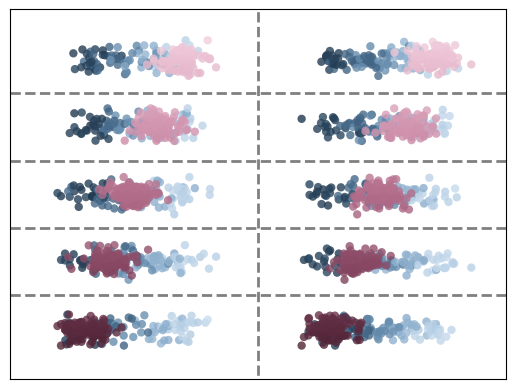

In [4]:
df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])


fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
thickness = 2
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
ax.plot([0,0],[-3,3], "k--", alpha=0.5, linewidth=thickness)
# x dividers
for i in y_values[:-1]:
    y = i+0.5-2
    ax.plot([-2,2],[y,y], "k--", alpha=0.5, linewidth=thickness)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
#native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
#intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

#ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
plt.legend().set_visible(False)
#plt.savefig("figs/example_divergence.png", dpi=600, bbox_inches="tight")

plt.show()

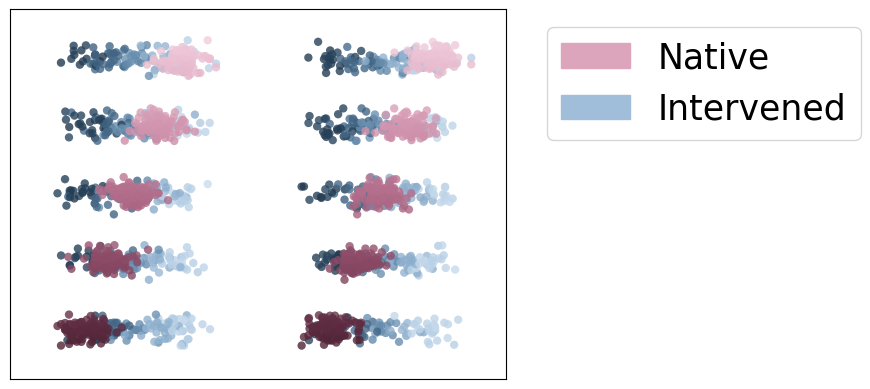

In [5]:
import matplotlib.patches as mpatches
import matplotlib as mpl

df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])



fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
#ax.plot([0,0],[-1,5], "k--", alpha=0.5)
## x dividers
#for i in y_values[:-1]:
#    y = i+0.5
#    ax.plot([-2,2],[y,y], "k--", alpha=0.5)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
#plt.savefig("figs/legend.png", dpi=600, bbox_inches="tight")

plt.show()

In [6]:
from geomloss import SamplesLoss
kwargs = {
    "loss": "sinkhorn",
    "p": 2,
    "blur": 0.05,
}
loss_fn = SamplesLoss(**kwargs)

def compute_emd(X,Y):
    return loss_fn(X.float(),Y.float())


# CL Loss

In [7]:
print(og_varbs.shape)
print(samples.shape)

(1000, 2)
(1000, 2)


In [8]:
def quick_plot(
    natty,
    intrv,
    natty_classes=None,
    intrv_classes=None,
    save_name=None,
    incl_legend=False,
    incl_dividers=True,
    xlim=[-2,2],
    ylim=[-2.75,2.75],
    incl_ticks=False,
    labels=["Native", "Intervened"],
    intrv_cmap=None,
    native_cmap=None,
    intrv_color=None,
    native_color=None,
    intrv_alpha = 0.95,
    native_alpha = 0.6,
    thickness=2,
    dash_alpha=0.5,
    legendsize = 25,
    dark = 0.2,
    light = 0.85,
    rot = 0,
    y_values=[i+0.5-2 for i in range(5)],
    rot_mtx=None,
    plot_rot_axes=True,
    figscale=1,
):
    
    fig = plt.figure(figsize=(3*figscale, 5*figscale))
    ax = plt.gca()
    
    if not incl_ticks:
        plt.xticks([])
        plt.yticks([])
    
    natty = natty.cpu().detach().numpy()
    intrv = intrv.cpu().detach().numpy()
    
    if natty_classes is None:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    elif len(set(intrv_classes))==1:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    else:
        if intrv_cmap is None:
            intrv_cmap = sns.color_palette("pastel")
        sns.scatterplot(
            x=intrv[:,0], y=intrv[:,1],
            alpha=intrv_alpha, ax=ax,
            hue=intrv_classes, palette=intrv_cmap
        )

    if natty_classes is None:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    elif len(set(natty_classes))==1:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    else:
        if native_cmap is None:
            native_cmap = sns.color_palette("dark")
        sns.scatterplot(
            x=natty[:,0],
            y=natty[:,1],
            alpha=native_alpha,
            ax=ax,
            hue=natty_classes,
            palette=native_cmap,
            edgecolor="none"
        )
        
    if incl_legend and natty_classes is None:
        native_patch = mpatches.Patch(color=native_color, label=labels[0])
        intrv_patch = mpatches.Patch(color=intrv_color, label=labels[1])
        ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
    elif incl_legend:
        plt.legend()
    else:
        plt.legend().set_visible(False)
        
    ## y divider
    if incl_dividers:
        ax.plot([0,0],[-3,3], "k--", linewidth=thickness, alpha=dash_alpha)
        # x dividers
        for y in y_values[:-1]:
            ax.plot([-2,2],[y,y], "k--", linewidth=thickness, alpha=dash_alpha)
    if rot_mtx is not None and plot_rot_axes:
        vec1 = rot_mtx.weight.data[:2,0]
        vec1 = vec1/vec1.norm()
        vec1 = vec1.cpu().numpy()
        ax.plot([0,3*vec1[0]], [0, 3*vec1[1]], "b--", linewidth=thickness, alpha=1)
        vec2 = rot_mtx.weight.data[:2,1]
        vec2 = vec2/vec2.norm()
        vec2 = vec2.cpu().numpy()
        ax.plot([0,3*vec2[0]], [0, 3*vec2[1]], "b--", linewidth=thickness, alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if save_name:
        plt.savefig(save_name, dpi=600, bbox_inches="tight")
    plt.show()    

In [9]:
def rot_fwd(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    return torch.matmul(vecs, mtx.weight ).float()

def rot_bck(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    inv = torch.linalg.inv(mtx.weight)
    return torch.matmul(vecs, inv ).float()

def interchange(trg,src,mtx,mask):
    """
    Patches the non-zero masked values from the src
    into the trg vectors in the rotated space.
    
    Args:
        trg: torch tensor (B,D)
        src: torch tensor (B,D)
        mtx: torch module (D,D)
            needs "weight" property
        mask: torch tensor (D,)
            ones denote dimensions that will be transferred
    """
    rot_trg = rot_fwd(trg, mtx)
    rot_src = rot_fwd(src, mtx)
    intrv = rot_trg*(1-mask) + rot_src*mask
    return rot_bck(intrv, mtx)

In [10]:
def normalize_fn(vecs, eps=1e-7):
    return (vecs-vecs.mean(0))/(vecs.std(0)+eps)

In [11]:
def get_classes_from_varbs(varbs, v2class=None):
    if v2class is None:
        v2class = dict()
    classes = []
    for v in varbs.detach().cpu().tolist():
        tup = tuple(v)
        if tup not in v2class:
            v2class[tup] = len(v2class)
        classes.append(v2class[tup])
    return np.asarray(classes), v2class
    

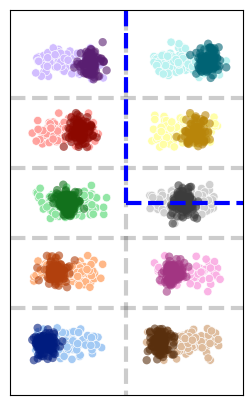

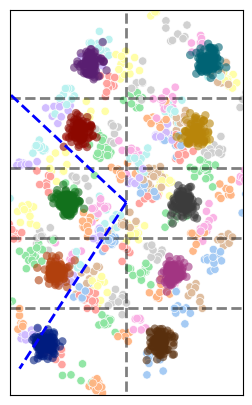

In [12]:
extra_dims = 0
cov = 0
mask_dims = 1

og_varbs = torch.tensor(og_varbs).long()
d = og_varbs.shape[-1] + extra_dims
mask = torch.zeros(d)
mask[:mask_dims] = 1

samples = torch.tensor(samples).float()
noise = torch.randn(len(og_varbs), extra_dims) + cov * torch.randn(len(og_varbs), extra_dims)*og_varbs[:,1:]
natty_varbs = og_varbs.clone()
natty_classes, v2class = get_classes_from_varbs(natty_varbs)
natty_samps = torch.cat([ samples, noise ], dim=-1)
perm = torch.randperm(len(og_varbs)).long()

intrv_varbs = torch.cat([ natty_varbs[:,0:1], natty_varbs[perm,1:] ], dim=-1)
intrv_classes, _ = get_classes_from_varbs(intrv_varbs, v2class=v2class)

trg_vecs = natty_samps[perm].clone()
src_vecs = natty_samps.clone()

eye = torch.nn.Linear(d,d)
eye.weight.data = torch.eye(d).float()
with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, eye, mask)

# Sanity check
quick_plot(
    natty_samps,
    intrv_samps,
    natty_classes=natty_classes,
    intrv_classes=intrv_classes,
    rot_mtx=eye,
    dash_alpha=0.2,
    thickness=3,
    save_name="figs/identity_patching.png",
)

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, rot_mtx, mask)

# Sanity check
quick_plot(natty_samps, intrv_samps, natty_classes=natty_classes, intrv_classes=intrv_classes, rot_mtx=rot_mtx)


In [13]:
for i,(iv,nv) in enumerate(zip(intrv_varbs,natty_varbs)):
    if tuple(iv.tolist())==tuple(nv.tolist()):
        assert natty_classes[i]==intrv_classes[i]

In [14]:
def train_classifier(
    vecs, classes,
    n_epochs=1000,
    lr=0.01,
    l2=0.01,
    drop_p=0.5,
    bsize=128,
    patience=500,
    print_every=50,
    n_layers=3,
    hidden_dim=256,
    pre_layernorm=False,
    pre_batchnorm=True,
    layernorm=False,
    batchnorm=True,
    model=None,
    ret_best=True,
    verbose=False,
    epoch_prog=False,
    device=0,
):
    """
    vecs: torch tensor (B,D)
    classes: list-like (B,)
    """
    classes = torch.tensor(classes).long()
    d = vecs.shape[-1]
    n = len(set(classes.detach().cpu().tolist()))
    if model is None:
        modules = []
        if pre_layernorm:
            modules.append(torch.nn.LayerNorm(d))
        if pre_batchnorm:
            modules.append(torch.nn.BatchNorm1d(d))
        if n_layers>2:
            modules += [
                torch.nn.Linear(d,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(drop_p),
            ]
            if layernorm:
                modules.append( torch.nn.LayerNorm(hidden_dim) )
            if batchnorm:
                modules.append( torch.nn.BatchNorm1d(hidden_dim) )
            d = hidden_dim
        if n_layers>1:
            modules += [
                torch.nn.Linear(d,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(drop_p),
            ]
            if layernorm:
                modules.append( torch.nn.LayerNorm(hidden_dim) )
            if batchnorm:
                modules.append( torch.nn.BatchNorm1d(hidden_dim) )
            d = hidden_dim
        modules.append(torch.nn.Linear(d,n))
        model = torch.nn.Sequential(*modules)
    if verbose:
        print(model)
    model.train()
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    optim.zero_grad()

    d = vecs.shape[-1]
    tlen = int(len(vecs)*0.8)
    train_vecs = vecs[:tlen]
    train_classes = classes[:tlen]
    valid_vecs = vecs[tlen:]
    valid_classes = classes[tlen:]
    prev_loss = np.inf
    best_loss = 0
    best_valid_loss = 0
    best_train_acc = 0
    best_valid_acc = 0
    n_pat = 0
    rng = range(n_epochs)
    if epoch_prog and not verbose:
        rng = tqdm(rng)
    for epoch in rng:
        model.train()
        perm = torch.randperm(len(train_vecs)).long()
        for b in range(0,max(len(perm)-bsize+1, 1),bsize):
            idxs = perm[b:b+bsize]
            inputs = train_vecs[idxs]
            labels = train_classes[idxs]
            preds = model(inputs.to(device))
            loss = torch.nn.functional.cross_entropy(preds, labels.to(device))
            loss.backward()
            optim.step()
            optim.zero_grad()
        with torch.no_grad():
            preds = model(train_vecs.to(device))
            train_acc = (preds.argmax(-1).cpu()==train_classes).float().mean()
            model.eval()
            preds = model(valid_vecs.to(device)).cpu()
            valid_acc = (preds.argmax(-1)==valid_classes).float().mean()
            valid_loss = torch.nn.functional.cross_entropy(preds, valid_classes)
        if epoch % print_every == 0 and verbose:
            print(epoch,
                  "TrnLoss:", loss.item(),
                  "ValLoss:", valid_loss.item(),
                  "TrnAcc:", train_acc.item(),
                  "ValAcc:", valid_acc.item()
                )
        if valid_acc>best_valid_acc or (valid_acc>=best_valid_acc and train_acc>best_train_acc):
            best_loss = loss
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            best_train_acc = train_acc
            best_model = copy.deepcopy(model)
        if valid_loss>=prev_loss:
            n_pat += 1
            if n_pat>=patience:
                print("Converged at epoch", epoch)
                break
        prev_loss = valid_loss.item()
        
    model.eval()
    if ret_best:
        print(epoch,
              "TrnLoss:", best_loss.item(),
              "ValLoss:", best_valid_loss.item(),
              "TrnAcc:", best_train_acc.item(),
              "ValAcc:", best_valid_acc.item()
            )
        return best_model, best_train_acc.item(), best_valid_acc.item()
    print(epoch,
          "TrnLoss:", loss.item(),
          "ValLoss:", valid_loss.item(),
          "TrnAcc:", train_acc.item(),
          "ValAcc:", valid_acc.item()
        )
    return model, train_acc.item(), valid_acc.item()

In [15]:
def get_cl_vectors(natty_varbs, intrv_varbs, natty_vecs, method="sample", varb_idx=None):
    """
    natty_varbs: tensor (B,2)
        the non-noisy variable values
    intrv_varbs: tensor (B,2)
        the non-noisy variable values
    natty_vecs: tensor (B,D)
        the noisy native vector representations
    method: str
        options: sample, mean
        determines whether the cl vectors should be averaged
        over all possible candidates or individual samples
    """
    cl_vectors = []
    all_idxs = torch.arange(len(natty_varbs)).long()
    for intrv in intrv_varbs:
        if varb_idx is None:
            valid_bools = (natty_varbs[:,0]==intrv[0])&(natty_varbs[:,1]==intrv[1])
        else:
            valid_bools = (natty_varbs[:,varb_idx]==intrv[varb_idx])
        valid_idxs = all_idxs[valid_bools]
        if method=="sample":
            idx = valid_idxs[int(np.random.randint(len(valid_idxs)))]
            cl_vectors.append(natty_vecs[idx])
        elif method in {"average", "mean"}:
            cl_vectors.append(natty_vecs[valid_idxs].mean(0))
    return torch.vstack(cl_vectors)

In [16]:
def calc_cl_loss(intrv, cl, cl_loss_type="both"):
    l2,cos,abs = 0,0,0
    if cl_loss_type in {"mse", "both"}:
        l2 = ((intrv-cl)**2).mean()
    if cl_loss_type in {"cos", "both"}:
        cos = 1-torch.nn.functional.cosine_similarity(intrv,cl)
    if cl_loss_type in {"abs"}:
        abs = torch.abs(intrv-cl)
    return l2 + cos + abs
    
def get_cl_loss(
    trg, src,
    mtx, mask,
    cl_vecs,
    empty_mask=None,
    incl_extra=True,
    n_varbs=2,
    calc_loss_in_aligned_basis=False,
    detach_cl_vecs=False,
    cl_loss_type="both",
    cl_1d=False,
    cl_varb_idxs=None,
):
    """
    Performs the interchange and computes the cl loss
    
    Args:
        trg: tensor (B,D)
            target vectors which will be patched into
        src: tensor (B,D)
            source vectors from which activity will be harvested
        mtx: torch module
            must have attribute "weight"
        cl_vecs: tensor (B,D)
        incl_extra: bool
            if true, the extraneous dimensions are included in
            the CL loss
        n_varbs: int
            the number of variables in the causal abstraction
        calc_loss_in_aligned_basis: bool
            if true, will compute cl loss in aligned basis
        detach_cl_vecs: bool
            if true, will detach the cl vectors from gradient
            calculations. otherwise, their rotation will be
            included in the loss.
        cl_loss_type: str
            options:
                "cos": cosine loss only
                "mse": mse loss only
                "both": add both cos and mse losses and divide by 2
        cl_1d: bool
            if true, will split the data and calculate the cl
            loss only along individual causal dimensions. Only
            applies if incl_extra is false.
        cl_varb_idxs: None or torch long tensor (B,)
            optionally specify the causal variable to use in the
            cl loss.
    """
    intrv = interchange(trg, src, mtx, mask)
    if empty_mask is not None:
        perm = torch.randperm(len(src)).long()
        intrv = interchange(intrv, src[perm], mtx, empty_mask)
        
    raw_intrv = intrv.clone()
    extra_dim = mask.long().sum()*n_varbs
    intrv = rot_fwd(intrv, mtx)
    cl_vecs = rot_fwd(cl_vecs, mtx)
    if not incl_extra:
        intrv[:,extra_dim:] = 0
        cl_vecs[:,extra_dim:] = 0
    
    # Isolate individual causal dimensions
    if cl_1d:
        dim1 = mask.long().sum()
        if cl_varb_idxs is not None:
            rows = torch.arange(len(intrv)).long()
            bools = cl_varb_idxs==0
            varb1_rows = rows[bools]
            varb2_rows = rows[~bools]
            intrv[varb1_rows,dim1:extra_dim] = 0
            intrv[varb2_rows,:dim1] = 0
            cl_vecs[varb1_rows,dim1:extra_dim] = 0
            cl_vecs[varb2_rows,:dim1] = 0
        else:
            half = len(intrv)//2
            intrv[:half,:dim1] = 0
            intrv[half:,dim1:extra_dim] = 0
            cl_vecs[:half,:dim1] = 0
            cl_vecs[half:,dim1:extra_dim] = 0
    if not calc_loss_in_aligned_basis:
        intrv = rot_bck(intrv, mtx)
        cl_vecs = rot_bck(cl_vecs, mtx)
    if detach_cl_vecs:
        cl_vecs = cl_vecs.detach().data
    return calc_cl_loss(intrv, cl_vecs, cl_loss_type=cl_loss_type).mean(), raw_intrv
    


In [17]:
def get_actn_loss(preds, labels):
    device = preds.get_device()
    if device<0: device = "cpu"
    labels = torch.tensor(labels).long().to(device)
    loss = torch.nn.functional.cross_entropy(preds, labels)
    acc = (preds.argmax(-1)==labels).float().mean()
    return loss, acc

### Training Loop

In [18]:
def prep_data(
    og_varbs,
    samples,
    v2class=None,
    extra_dims = 128, # total number of additional noise dimensions
    dupl_rank = 0, # number of additional dimensions that are exact duplicates
    zero_rank = 0, # number of dimensions to zero out
    mask_dims=1, # number of dimensions in the DAS mask
    cov_strength = 1, # how much do the extraneous dimensions covary with the x and y values,
    n_samples_per_class=None,
    normalize=False,
    excl_classes=None,
    excl_tups=None,
):
    """
    Constructs the dataset from the samples.
    """
    dupl_rank = min(extra_dims-1, dupl_rank)
    
    d = og_varbs.shape[-1] + extra_dims
    mask = torch.zeros(d)
    mask[:mask_dims] = 1

    if extra_dims>0:
        n_noise_dims = extra_dims-dupl_rank
        if extra_dims>1:
            noise = torch.randn(len(og_varbs), n_noise_dims) +\
                torch.cat([
                    cov_strength * torch.randn(len(og_varbs), n_noise_dims//2)*og_varbs[:,1:],
                    cov_strength * torch.randn(len(og_varbs), n_noise_dims//2)*og_varbs[:,0:1]
                ],dim=-1)
        else:
            noise = torch.randn(len(og_varbs), n_noise_dims) + cov_strength * torch.randn(len(og_varbs), n_noise_dims)*og_varbs[:,1:]
            
        if dupl_rank>0:
            idxs = torch.randint(0,noise.shape[-1],(dupl_rank,)).long()
            dupls = noise.T[idxs].T
            noise = torch.cat([noise,dupls],dim=-1)
        if zero_rank>0:
            # Instead of just zeroing out dimensions, we reduce the rank of the noise
            # in a rotated basis.
            n = noise.shape[-1]
            orth = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(n,n))
            with torch.no_grad():
                noise = torch.matmul(noise, orth.weight)
                noise[:,:zero_rank] = 0
                noise = torch.matmul(noise, orth.weight.T)
        natty_vecs = torch.cat([
            torch.tensor(samples).float(), noise
        ], dim=-1)
    else: natty_vecs = torch.tensor(samples).float()
    natty_varbs = torch.tensor(og_varbs).long()
    natty_classes, v2class = get_classes_from_varbs(natty_varbs, v2class=v2class)
    natty_classes = torch.tensor(natty_classes).long()
    if normalize:
        natty_vecs = (natty_vecs-natty_vecs.mean(0))/natty_vecs.std()

    if not n_samples_per_class or n_samples_per_class<0:
        perm = torch.randperm(len(og_varbs)).long()
        intrv_idxs = torch.stack([
            torch.arange(len(og_varbs)).long(), perm
        ],dim=1)
    
        intrv_varbs = torch.cat([ natty_varbs[:,0:1], natty_varbs[perm,1:] ], dim=-1)
        intrv_classes, intrv_v2class = get_classes_from_varbs(intrv_varbs, v2class={**v2class})
        intrv_classes = torch.tensor(intrv_classes).long()
        if len(intrv_v2class)!=len(v2class):
            valid_intrvs = torch.isin(intrv_classes, torch.tensor(list(v2class.values())).long())
        else:
            valid_intrvs = torch.ones(len(intrv_classes)).bool()
        if excl_classes is not None:
            valid_intrvs = valid_intrvs&(torch.tensor([int(c) not in excl_classes for c in intrv_classes]).bool())
        if excl_tups is not None:
            valid_intrvs = valid_intrvs&(torch.tensor([
                tuple(int(c[0]),int(c[1])) not in excl_tups for c in intrv_varbs]).bool())

        trg_vecs = natty_vecs[perm].clone()
        src_vecs = natty_vecs.clone()
    else:
        intrv_v2class = {**v2class}
        c2varb = {v:k for k,v in v2class.items()}
        n_classes = len(v2class)
        intrv_classes = []
        intrv_idxs = []
        intrv_varbs = []
        arange = torch.arange(len(natty_varbs)).long()
        for c,varb_tup in c2varb.items():
            if excl_classes is not None and c in excl_classes:
                continue
            if excl_tups is not None and varb_tup in excl_tups:
                print("Skipping", varb_tup)
                continue
            for samp in range(n_samples_per_class):
                idxs1 = arange[(natty_varbs[:,0]==varb_tup[0])]
                idx1 = idxs1[int(np.random.randint(len(idxs1)))]
                idxs2 = arange[(natty_varbs[:,1]==varb_tup[1])]
                if len(idxs2)==0:
                    break # skip class if impossible
                idx2 = idxs2[int(np.random.randint(len(idxs2)))]
                intrv_idxs.append([int(idx1),int(idx2)])
                intrv_classes.append(c)
                intrv_varbs.append([varb_tup[0], varb_tup[1]])
                assert natty_varbs[idx1,0]==varb_tup[0] and natty_varbs[idx2,1]==varb_tup[1]
        intrv_idxs = torch.tensor(intrv_idxs).long()
        intrv_classes = torch.tensor(intrv_classes).long()
        intrv_varbs = torch.tensor(intrv_varbs).long()
        valid_intrvs = torch.ones(len(intrv_classes)).bool()
        
        trg_vecs = natty_vecs[intrv_idxs[:,1]].clone()
        src_vecs = natty_vecs[intrv_idxs[:,0]].clone()
        natty_varbs = natty_varbs[intrv_idxs[:,0]]
        natty_classes = natty_classes[intrv_idxs[:,0]]
        natty_vecs = src_vecs.clone()
                             
    return {
        "intrv_idxs": intrv_idxs,
        
        "mask": mask.clone(),
        "src_vecs": src_vecs.clone(),
        "trg_vecs": trg_vecs.clone(),
        "intrv_varbs": intrv_varbs.clone(),
        "intrv_classes": intrv_classes.clone(),
        "valid_intrvs": valid_intrvs.clone(),
        "src_varbs": natty_varbs.clone(),
        "intrv_v2class": intrv_v2class,
        "src_classes": natty_classes.clone(),
        "v2class": v2class,
    }

In [19]:
def get_plot_save_name(params, excl_keys={"calc_loss_in_aligned_basis", "lr", "n_epochs", "detach_cl_vecs"}):
    s = "toydiv"
    for k in sorted(list(params.keys())):
        if k in excl_keys: continue
        v = params[k]
        s+= f"_{k}{v}"
    return s+".png"

In [20]:
import copy

def train_rotation(
    src_varbs, intrv_varbs, classifier,
    trg_vecs, src_vecs,
    src_classes, intrv_classes,
    mask=None,
    n_epochs = 1000,
    lr = 0.01,
    cl_eps = 1,
    cl_loss_type="both",#"cos" "mse" "both"
    cl_1d=False, # use the 1d cl vector objective
    method = "mean",  #"mean" "sample"
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = False,
    incl_actn_loss = False,
    incl_cl_loss = True,
    mtx_type = "orthog", # "orthog" "linear",
    print_every = 50,
    fig_every = 200,
    save_fig=False,
    shuffle_empty=False,
    incl_dividers=False,
    early_stopping=True,
    early_stop_thresh=1e-5,
    early_stop_patience=100,
    rot_dtype="float",
    verbose=True,
    **kwargs,
):
    exp_params = {
        "n_epochs": n_epochs,
        "lr": lr,
        "method": method,
        "incl_extra": incl_extra,
        "calc_loss_in_aligned_basis": calc_loss_in_aligned_basis,
        "detach_cl_vecs": detach_cl_vecs,
        "incl_actn_loss": incl_actn_loss,
        "incl_cl_loss": incl_cl_loss,
        "mtx_type": mtx_type,
        "cl_eps": cl_eps,
    }
    if verbose:
        print("Actn Loss:", incl_actn_loss)
        print("CL Loss:", incl_cl_loss)

    d = src_vecs.shape[-1]
    assert incl_actn_loss or incl_cl_loss
    if cl_1d:
        perm = torch.randperm(len(src_varbs)).long()
        half = len(src_varbs)//2
        cl_vecs = torch.empty_like(src_vecs)
        cl_varb_idxs = torch.zeros(len(src_varbs)).long()
        cl_varb_idxs[perm[half:]] = 1
        cl_vecs[perm[:half]] = get_cl_vectors(
            src_varbs[perm[:half]],
            intrv_varbs[perm[:half]],
            src_vecs[perm[:half]],
            method=method,
            varb_idx=0
        )
        cl_vecs[perm[half:]] = get_cl_vectors(
            src_varbs[perm[half:]],
            intrv_varbs[perm[half:]],
            src_vecs[perm[half:]],
            method=method,
            varb_idx=1
        )
    else:
        cl_varb_idxs = None
        cl_vecs = get_cl_vectors(src_varbs, intrv_varbs, src_vecs, method=method)
    if mask is None:
        mask = torch.zeros(d)
        mask[:1] = 1
    empty_mask = None
    if shuffle_empty:
        empty_mask = torch.zeros_like(mask).cuda()
        empty_mask[int(mask.long().sum())*2:] = 1

    # eye = torch.nn.Linear(d,d)
    # eye.weight.data = torch.eye(d).float()
    # rot_mtx = eye
    if mtx_type=="linear":
        rot_mtx = SymmetricDefiniteMatrix( size=d, )
    elif "orthog" in mtx_type:
        rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))
    else:
        raise NotImplemented
    if rot_dtype=="double":
        rot_mtx.double()
    optim = torch.optim.Adam(rot_mtx.parameters(), lr=lr)
    optim.zero_grad()

    with torch.no_grad():
        eye = torch.nn.Linear(d,d)
        eye.weight.data = torch.eye(d).float()
        intrv_vecs = interchange(trg_vecs, src_vecs, eye, mask)
    #quick_plot(intrv_vecs, src_vecs, intrv_classes, src_classes, )
    if fig_every<np.inf and verbose:
        print("Identity")
        quick_plot(
            src_vecs, intrv_vecs.detach(),
            src_classes, intrv_classes,
            save_name="figs/identity.png",
            incl_dividers=incl_dividers
        )
        if incl_cl_loss:
            print("CL Vectors")
            quick_plot(
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                intrv_classes, intrv_classes,
                incl_dividers=incl_dividers
            )

    with torch.no_grad():
        intrv_vecs = interchange(trg_vecs, src_vecs, rot_mtx, mask)
    #quick_plot(intrv_vecs, src_vecs, intrv_classes, src_classes, )
    if fig_every<np.inf and verbose:
        print("Untrained")
        quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, incl_dividers=incl_dividers, rot_mtx=rot_mtx)

    print("Training Rotation")
    n_pat = 0
    best_acc = 0
    best_loss = np.inf
    best_emd = np.inf
    best_row_emd = np.inf
    bestemd_row_emd = np.inf
    bestloss_loss = np.inf
    for epoch in range(n_epochs):
        cl_loss, intrv_vecs = get_cl_loss(
            trg=trg_vecs.cuda(),
            src=src_vecs.cuda(),
            mtx=rot_mtx.cuda(),
            mask=mask.cuda(),
            empty_mask=empty_mask,
            cl_vecs=cl_vecs.cuda(),
            incl_extra=incl_extra,
            calc_loss_in_aligned_basis=calc_loss_in_aligned_basis,
            detach_cl_vecs=detach_cl_vecs,
            cl_loss_type=cl_loss_type,
            cl_1d=cl_1d,
            cl_varb_idxs=cl_varb_idxs,
        )
        with torch.no_grad():
            perm = torch.randperm(len(src_vecs)).long()
            emd = compute_emd(src_vecs[perm].cuda(), intrv_vecs.cuda()).item()
            extra_mask = torch.zeros_like(mask).cuda()
            extra_mask[:2] = 1 # Only using the causal dimensions
            row_emd = compute_emd(
                intrv_vecs.cuda()*extra_mask, src_vecs.cuda()*extra_mask
            ).item()
            
        actn_loss, acc = get_actn_loss(classifier(intrv_vecs), intrv_classes)
        loss = 0
        if incl_actn_loss:
            loss += actn_loss
        if incl_cl_loss:
            loss += cl_eps*cl_loss
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        if epoch % print_every == 0 and verbose:
            print(epoch, "Cl Loss:", cl_loss.item(), "ActLoss:", actn_loss.item(), "Actn:", acc.item(), "EMD:", emd, "RowEMD", row_emd)
        if epoch % fig_every == 0 and epoch > 0:
            quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, incl_dividers=incl_dividers, rot_mtx=rot_mtx)
            
        if acc>best_acc:
            best_acc = acc
            best_mtx = copy.deepcopy(rot_mtx)
            best_cl_loss = cl_loss
            best_actn_loss = actn_loss
            best_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            best_emd = emd
            best_row_emd = row_emd
        if loss<bestloss_loss or (loss<=bestloss_loss and acc>=bestloss_acc):
            bestloss_acc = acc
            bestloss_loss = loss.item()
            bestloss_mtx = copy.deepcopy(rot_mtx)
            bestloss_cl_loss = cl_loss
            bestloss_actn_loss = actn_loss
            bestloss_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            bestloss_emd = emd
            bestloss_row_emd = row_emd
        if row_emd<bestemd_row_emd or (row_emd<=bestemd_row_emd and acc>=bestemd_acc):
            bestemd_row_emd = row_emd
            bestemd_emd = emd
            bestemd_loss = loss.item()
            bestemd_mtx = copy.deepcopy(rot_mtx)
            bestemd_cl_loss = cl_loss
            bestemd_actn_loss = actn_loss
            bestemd_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            bestemd_acc = acc
            
        if loss>=(bestloss_loss-early_stop_thresh) and early_stopping:
            n_pat += 1
            if n_pat>early_stop_patience:
                print("Converged at epoch", epoch)
                break
        else:
            n_pat = 0
        if acc.item()==1 and early_stopping and epoch>=early_stop_patience:
            print("Converged at epoch", epoch)
            break


    if verbose:
        for p in sorted(list(exp_params.keys())):
            print(p, exp_params[p])
    print()
    if (fig_every<np.inf and verbose) or save_fig:
        if incl_cl_loss:
            print("CL Vectors")
            quick_plot(
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                intrv_classes, intrv_classes,
                incl_dividers=incl_dividers,
                rot_mtx=best_mtx,
            )
        save_name = "figs/"+get_plot_save_name(exp_params)
        print("Best Checkpt (by Train Acc)")
        quick_plot(
            src_vecs, best_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name.replace(".png", "_byacc.png") if save_fig else None,
            incl_dividers=incl_dividers,
            rot_mtx=best_mtx,
        )
        print("Best Checkpt (by Train Loss)")
        quick_plot(
            src_vecs, bestloss_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name.replace(".png", "_byloss.png") if save_fig else None,
            incl_dividers=incl_dividers,
            rot_mtx=bestloss_mtx,
        )
        print("Best Checkpt (by EMD)")
        quick_plot(
            src_vecs, bestemd_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name.replace(".png", "_byemd.png") if save_fig else None,
            incl_dividers=incl_dividers,
            rot_mtx=bestemd_mtx,
        )
        print("Last Checkpt")
        quick_plot(
            src_vecs, intrv_vecs,
            src_classes, intrv_classes,
            incl_dividers=incl_dividers,
            save_name=save_name.replace(".png", "_last.png") if save_fig else None,
            rot_mtx=rot_mtx,
        )
    if verbose:
        print("Best (by Acc) - ",
            "Cl Loss:", best_cl_loss.item(),
              "ActLoss:", best_actn_loss.item(),
              "Actn:", best_acc.item(),
              "EMD:", best_emd,
             "RowEMD:", best_row_emd)
        print("Best (by EMD) - ",
            "Cl Loss:", bestemd_cl_loss.item(),
              "ActLoss:", bestemd_actn_loss.item(),
              "Actn:", bestemd_acc.item(),
              "EMD:", bestemd_emd,
             "RowEMD:", bestemd_row_emd)
        print(f"Last {epoch} - ",
              "Cl Loss:", cl_loss.item(),
              "ActLoss:", actn_loss.item(),
              "Actn:", acc.item(),
              "EMD:", emd,
              "RowEMD", row_emd
             )
    best_metrics = {
        "cl_loss": best_cl_loss,
        "actn_loss": best_actn_loss,
        "acc": best_acc,
        "emd": best_emd,
        "row_emd": best_row_emd,
        "mtx": best_mtx,
    }
    bestloss_metrics = {
        "cl_loss": bestloss_cl_loss,
        "actn_loss": bestloss_actn_loss,
        "acc": bestloss_acc,
        "emd": bestloss_emd,
        "row_emd": bestloss_row_emd,
        "mtx": bestloss_mtx,
    }
    bestemd_metrics = {
        "cl_loss": bestemd_cl_loss,
        "actn_loss": bestemd_actn_loss,
        "acc": bestemd_acc,
        "emd": bestemd_emd,
        "row_emd": bestemd_row_emd,
        "mtx": bestemd_mtx,
    }
    ret_dict = {
        "last_mtx": rot_mtx,
        "exp_params": exp_params,
        "best_metrics": best_metrics,
        "bestloss_metrics": bestloss_metrics,
        "bestemd_metrics": bestemd_metrics,
    }
    return ret_dict


Identity
Div: tensor(3.5946)


/tmp/ipykernel_2971930/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2971930/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


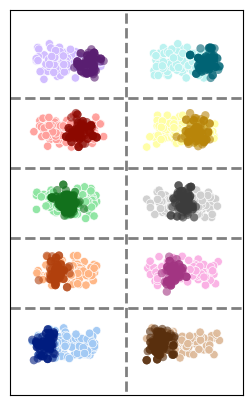

Untrained
Div: tensor(3.6482)


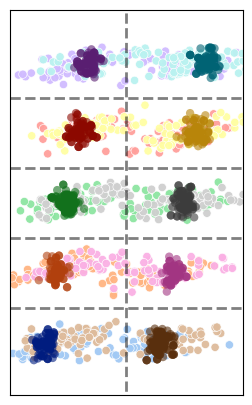

In [21]:
extra_dims = 16 # adds extra noisy dimensions
dupl_rank = 0 # duplicates uniformly sampled extra dimensions from the set of extra_dims-dupl_rank noisy dimensions
zero_rank = 0
mask_dims = 1 # note that you will need to increase this if adding zero_rank or dupl_rank dimensions to the
    # representations. The reason is that it is possible to learn a trivial solution to the CL loss where
    # it only fits to the zero/duplicated dimensions. This will be reflected in the accuracy.
cov_strength = 0 # how much do the extraneous dimensions covary with the x and y values
normalize = False

np.random.seed(12345)
torch.manual_seed(12345)

data_dict = prep_data(
    og_varbs=og_varbs,
    samples=samples,
    v2class=v2class,
    extra_dims=extra_dims,
    dupl_rank=dupl_rank,
    zero_rank=zero_rank,
    mask_dims=mask_dims,
    cov_strength=cov_strength,
    n_samples_per_class=100,
    normalize=normalize
)

mask = data_dict["mask"]
valids = data_dict["valid_intrvs"]
src_vecs = data_dict["src_vecs"][valids]
trg_vecs = data_dict["trg_vecs"][valids]
intrv_idxs = data_dict["intrv_idxs"][valids]
intrv_varbs = data_dict["intrv_varbs"][valids]
intrv_classes = data_dict["intrv_classes"][valids]
src_classes = data_dict["src_classes"][valids]
src_varbs = data_dict["src_varbs"][valids]


d = src_vecs.shape[-1]
mask = torch.zeros(d)
mask[:mask_dims] = 1
empty_mask = torch.zeros_like(mask)
if len(mask)>mask_dims*2:
    empty_mask[mask_dims*2:] = 1

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    eye = torch.nn.Linear(d,d)
    eye.weight.data = torch.eye(d).float()
    intrv_vecs = interchange(trg_vecs, src_vecs, eye, mask)
print("Identity")
div = compute_emd(src_vecs, intrv_vecs)
print("Div:", div)
quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, )

with torch.no_grad():
    intrv_vecs = interchange(trg_vecs, src_vecs, rot_mtx, mask)
print("Untrained")
div = compute_emd(src_vecs, intrv_vecs)
print("Div:", div)
quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, )


In [22]:
lr = 0.01
bsize = 200
patience = 100
l2 = 0.005
n_epochs = 1000
drop_p = 0.5
hidden_dim = 128
n_layers = 2 # 1-3 layers 
pre_layernorm = False
layernorm = False
pre_batchnorm = True
batchnorm = True

np.random.seed(12345)
torch.manual_seed(12345)
print("Training Classifier")
classifier, max_acc, _ = train_classifier(
    #normalize_fn(src_vecs),
    src_vecs,
    src_classes,
    lr=lr,
    patience=patience,
    l2=l2,
    hidden_dim=hidden_dim,
    n_epochs=n_epochs,
    drop_p=drop_p,
    bsize=bsize,
    n_layers=n_layers,
    pre_layernorm=pre_layernorm,
    pre_batchnorm=pre_batchnorm,
    layernorm=layernorm,
    batchnorm=batchnorm,
    #model=model,
    ret_best=True,
    verbose=True,
)
classifier.cuda()
classifier.eval()
for p in classifier.parameters():
    p.requires_grad = False

Training Classifier
Sequential(
  (0): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=18, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=128, out_features=10, bias=True)
)


/tmp/ipykernel_2971930/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


0 TrnLoss: 2.014617919921875 ValLoss: 2.09018611907959 TrnAcc: 0.41499999165534973 ValAcc: 0.29499998688697815
50 TrnLoss: 0.1049584224820137 ValLoss: 0.08669961243867874 TrnAcc: 0.9962499737739563 ValAcc: 1.0
100 TrnLoss: 0.10783591866493225 ValLoss: 0.0711519718170166 TrnAcc: 0.9937499761581421 ValAcc: 1.0
150 TrnLoss: 0.1334782838821411 ValLoss: 0.07789638638496399 TrnAcc: 0.9950000047683716 ValAcc: 1.0
200 TrnLoss: 0.12967905402183533 ValLoss: 0.07138537615537643 TrnAcc: 0.9937499761581421 ValAcc: 1.0
Converged at epoch 236
236 TrnLoss: 0.11017090082168579 ValLoss: 0.09281247854232788 TrnAcc: 1.0 ValAcc: 1.0


Actn Loss: False
CL Loss: True
Identity


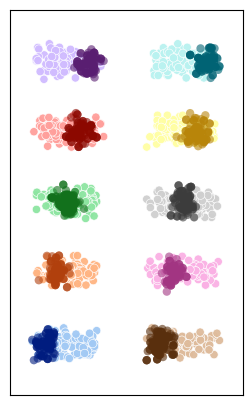

CL Vectors


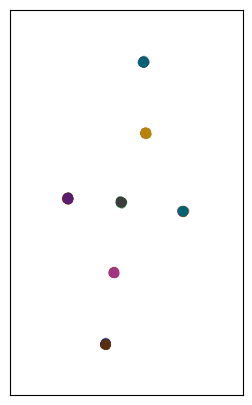

Untrained


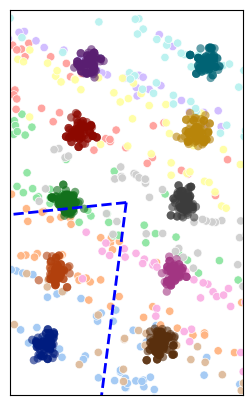

Training Rotation


/tmp/ipykernel_2971930/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


0 Cl Loss: 0.7434343099594116 ActLoss: 8.031124114990234 Actn: 0.33800002932548523 EMD: 18.742778778076172 RowEMD 4.99746036529541
50 Cl Loss: 0.0935792550444603 ActLoss: 0.14167074859142303 Actn: 0.9920000433921814 EMD: 3.6110007762908936 RowEMD 0.02254190295934677
100 Cl Loss: 0.08315042406320572 ActLoss: 0.13363589346408844 Actn: 0.9940000176429749 EMD: 3.577732801437378 RowEMD 0.016422655433416367
150 Cl Loss: 0.090947225689888 ActLoss: 0.11513913422822952 Actn: 0.9980000257492065 EMD: 3.5734667778015137 RowEMD 0.012610234320163727
200 Cl Loss: 0.08482296764850616 ActLoss: 0.1031157374382019 Actn: 0.9980000257492065 EMD: 3.5702242851257324 RowEMD 0.010186079889535904
250 Cl Loss: 0.07875116169452667 ActLoss: 0.0960836410522461 Actn: 0.999000072479248 EMD: 3.567772626876831 RowEMD 0.008719708770513535


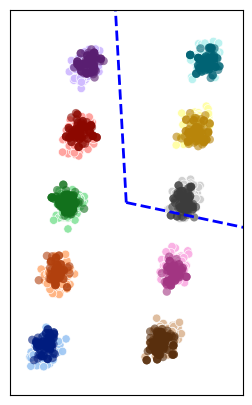

/tmp/ipykernel_2971930/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


300 Cl Loss: 0.0847075879573822 ActLoss: 0.09190156310796738 Actn: 0.999000072479248 EMD: 3.56581449508667 RowEMD 0.007785898633301258
350 Cl Loss: 0.08667907863855362 ActLoss: 0.08925281465053558 Actn: 1.0 EMD: 3.5642478466033936 RowEMD 0.00716116838157177
400 Cl Loss: 0.08665955066680908 ActLoss: 0.08747515827417374 Actn: 1.0 EMD: 3.562988519668579 RowEMD 0.0067194728180766106
450 Cl Loss: 0.09064540266990662 ActLoss: 0.08622215688228607 Actn: 1.0 EMD: 3.561923027038574 RowEMD 0.006393093150109053
calc_loss_in_aligned_basis False
cl_eps 50
detach_cl_vecs True
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.025
method mean
mtx_type linear
n_epochs 500

CL Vectors


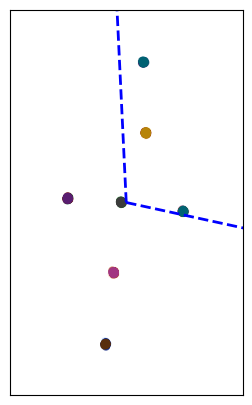

Best Checkpt (by Train Acc)


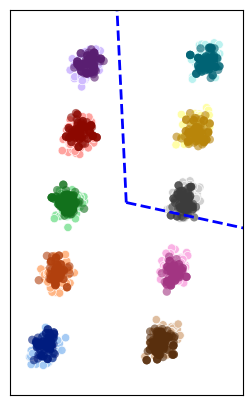

Best Checkpt (by Train Loss)


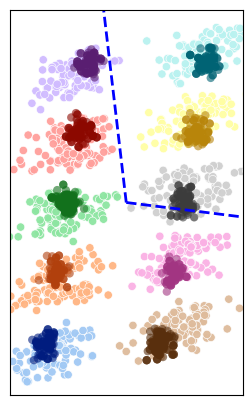

Best Checkpt (by EMD)


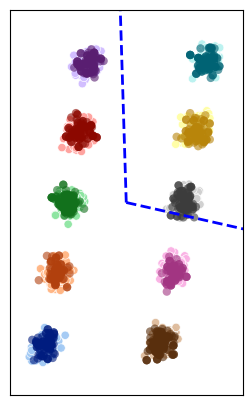

Last Checkpt


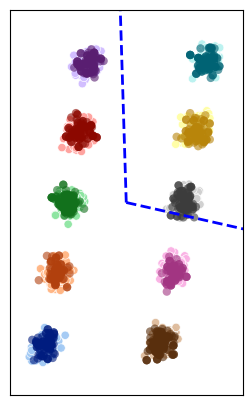

Best (by Acc) -  Cl Loss: 0.08470550924539566 ActLoss: 0.09170834720134735 Actn: 1.0 EMD: 3.5657095909118652 RowEMD: 0.007741249166429043
Best (by EMD) -  Cl Loss: 0.09263534843921661 ActLoss: 0.08531725406646729 Actn: 1.0 EMD: 3.5610179901123047 RowEMD: 0.006147458218038082
Last 499 -  Cl Loss: 0.09263534843921661 ActLoss: 0.08531725406646729 Actn: 1.0 EMD: 3.5610179901123047 RowEMD 0.006147458218038082


In [23]:
# Run the CL Loss only
lr = 0.025
cl_eps = 50
mask_dims = 1
n_epochs = 500
fig_every = 250
mtx_type = "linear" # "orthog" "linear",
cl_1d = True
rot_dtype = "float"
cl_loss_type = "both"
early_stop_patience = 500
incl_extra = False

d = src_vecs.shape[-1]
mask = torch.zeros(d)
mask[:mask_dims] = 1

np.random.seed(12345)
torch.manual_seed(12345)
ret_dict = train_rotation(
    src_varbs=src_varbs,
    intrv_varbs=intrv_varbs,
    classifier=classifier,
    trg_vecs=trg_vecs,
    src_vecs=src_vecs,
    src_classes=src_classes,
    intrv_classes=intrv_classes,
    mask=mask,
    cl_loss_type = cl_loss_type, #"cos", "mse", "both
    method = "mean",  #"mean" "sample"
    detach_cl_vecs = True,
    shuffle_empty = False,
    incl_extra = incl_extra, # Will include the extraneous subspaces in cl loss if True,
    calc_loss_in_aligned_basis = False,
    cl_1d = cl_1d,
    rot_dtype=rot_dtype,
    lr = lr,
    cl_eps=cl_eps,
    early_stopping=True,
    early_stop_patience=early_stop_patience,
    incl_actn_loss = False,
    incl_cl_loss = True,
    mtx_type = mtx_type, # "orthog" "linear",
    print_every = 50,
    n_epochs = n_epochs,
    fig_every = fig_every,
    save_fig=True,
    incl_dividers=False,
)

Actn Loss: True
CL Loss: False
Identity


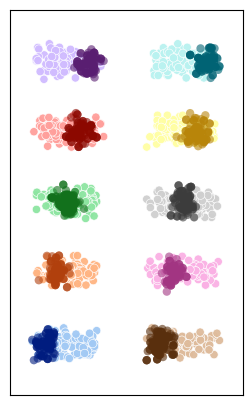

Untrained


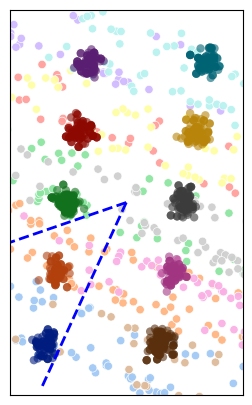

Training Rotation
0 Cl Loss: 3.08693790435791 ActLoss: 7.657404899597168 Actn: 0.3620000183582306 EMD: 20.297035217285156 RowEMD 5.619479656219482


/tmp/ipykernel_2971930/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


50 Cl Loss: 0.3559226095676422 ActLoss: 0.08985848724842072 Actn: 0.999000072479248 EMD: 4.427948951721191 RowEMD 0.027340276166796684
100 Cl Loss: 0.40624698996543884 ActLoss: 0.08134815841913223 Actn: 1.0 EMD: 4.287175178527832 RowEMD 0.013367229141294956
150 Cl Loss: 0.4379587471485138 ActLoss: 0.0805780366063118 Actn: 1.0 EMD: 4.3008527755737305 RowEMD 0.012766366824507713
200 Cl Loss: 0.44279518723487854 ActLoss: 0.08014237880706787 Actn: 1.0 EMD: 4.2950849533081055 RowEMD 0.012324278242886066
250 Cl Loss: 0.42561930418014526 ActLoss: 0.07980955392122269 Actn: 1.0 EMD: 4.294316291809082 RowEMD 0.012016262859106064


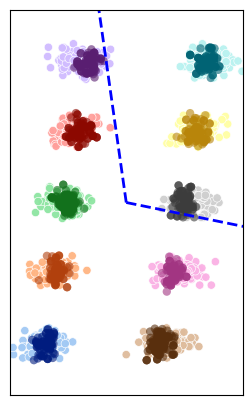

/tmp/ipykernel_2971930/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


300 Cl Loss: 0.3976250886917114 ActLoss: 0.07953476160764694 Actn: 1.0 EMD: 4.300942420959473 RowEMD 0.011800386011600494
350 Cl Loss: 0.3672836422920227 ActLoss: 0.07929084450006485 Actn: 1.0 EMD: 4.319260597229004 RowEMD 0.01174857746809721
400 Cl Loss: 0.3407825231552124 ActLoss: 0.07906784862279892 Actn: 1.0 EMD: 4.336130142211914 RowEMD 0.011698043905198574
450 Cl Loss: 0.3175083100795746 ActLoss: 0.0788584053516388 Actn: 1.0 EMD: 4.3548583984375 RowEMD 0.011694935150444508
calc_loss_in_aligned_basis False
cl_eps 50
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.025
method mean
mtx_type linear
n_epochs 500

Best Checkpt (by Train Acc)


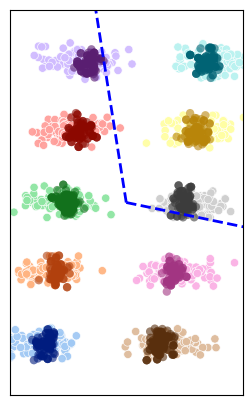

Best Checkpt (by Train Loss)


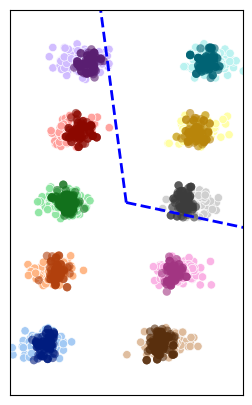

Best Checkpt (by EMD)


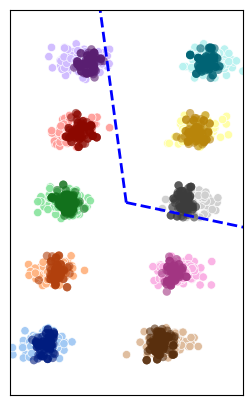

Last Checkpt


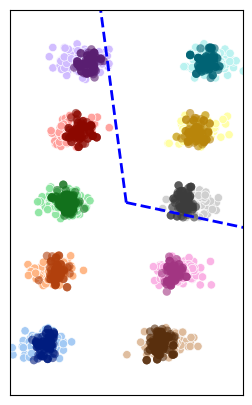

Best (by Acc) -  Cl Loss: 0.36274683475494385 ActLoss: 0.08878441900014877 Actn: 1.0 EMD: 4.543661117553711 RowEMD: 0.026722121983766556
Best (by EMD) -  Cl Loss: 0.3292936086654663 ActLoss: 0.07896553725004196 Actn: 1.0 EMD: 4.344336986541748 RowEMD: 0.011687761172652245
Last 499 -  Cl Loss: 0.2970873713493347 ActLoss: 0.07866905629634857 Actn: 1.0 EMD: 4.378830909729004 RowEMD 0.011735091917216778


In [24]:
# Run the behavioral loss only
np.random.seed(12345)
torch.manual_seed(12345)
ret_dict = train_rotation(
    src_varbs=src_varbs,
    intrv_varbs=intrv_varbs,
    classifier=classifier,
    trg_vecs=trg_vecs,
    src_vecs=src_vecs,
    src_classes=src_classes,
    intrv_classes=intrv_classes,
    mask=mask,
    #cl_loss_type = "both", #"cos", "mse", "both
    method = "mean",  #"mean" "sample"
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = True,
    shuffle_empty = False,
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    lr = lr,
    cl_eps=cl_eps,
    early_stopping=True,
    early_stop_patience=early_stop_patience,
    incl_actn_loss = True,
    incl_cl_loss = False,
    mtx_type = mtx_type, # "orthog" "linear",
    print_every = 50,
    n_epochs = n_epochs,
    fig_every = fig_every,
    save_fig=True,
    incl_dividers=False,
)


# Multi Tasking

In [25]:
def test_rotation(
        rot_mtx,
        data,
        classifier,
        mask=None,
        incl_extra=False,
        calc_loss_in_aligned_basis=False,
        detach_cl_vecs=False,
        method="mean",
        ylim=[-2.75,1.75],
        fig_save_name=None,
        verbose=False,
        **kwargs,
):
    cl_vecs = get_cl_vectors(
        data["src_varbs"], data["intrv_varbs"], data["src_vecs"], method=method
    )
    if mask is None:
        mask = torch.zeros(src_vecs.shape[-1]).cuda()
        mask[0] = 1

    cl_loss, intrv_vecs = get_cl_loss(
        trg=data["trg_vecs"].cuda(),
        src=data["src_vecs"].cuda(),
        mtx=rot_mtx.cuda(),
        mask=mask.cuda(),
        cl_vecs=cl_vecs.cuda(),
        incl_extra=incl_extra,
        calc_loss_in_aligned_basis=calc_loss_in_aligned_basis,
        detach_cl_vecs=detach_cl_vecs,
    )
    with torch.no_grad():
        src_vecs = data["src_vecs"]
        perm = torch.randperm(len(src_vecs)).long()
        emd = compute_emd(src_vecs[perm].cuda(), intrv_vecs.cuda()).item()
        extra_mask = torch.zeros_like(mask).cuda()
        extra_mask[:2] = 1 # Only using the causal dimensions
        row_emd = compute_emd(
            intrv_vecs.cuda()*extra_mask, src_vecs.cuda()*extra_mask
        ).item()
    actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())

    if verbose:
        print("Cl Loss:", cl_loss.item(), "ActLoss:", actn_loss.item(), "Actn:", acc.item(), "EMD:", emd, "RowEMD:", row_emd)
        quick_plot(
            data["src_vecs"], intrv_vecs.detach(),
            data["src_classes"], data["intrv_classes"],
            ylim=ylim,
            incl_dividers=False,
            save_name=fig_save_name,
        )
    return cl_loss, actn_loss, acc, emd, row_emd

### Task Exploration

Sorry this is so messy...

In [26]:
import time
from toytask_utils import all_divisions
from datetime import datetime

In [27]:
all_divisions

['og_noholdouts',
 'og_holdouts',
 'shared_y',
 'shared_y_overlap',
 'tetris_L',
 'mirror_L',
 'tetris_T',
 'tetris_T_no_overlap',
 'tetris_C',
 'tetris_h',
 'mirror_h',
 'tetris_F',
 'mirror_F',
 'random',
 'random_overlap',
 'inner_square',
 'xor',
 'distinct_xy_overlap',
 'distinct_xy',
 'distinct_y_overlap',
 'distinct_y']

In [28]:
divisions = ["inner_square", "og_noholdouts", "og_holdouts", "xor"]

In [128]:
csv_id = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(csv_id)

data_params = {
    "extra_dims": 16,
    "dupl_rank": 0, # duplicates extra dims
    "zero_rank": 0, # zeros out extra dims in a rotated space
    "cov_strength": 0, # how much do the extraneous dimensions covary with the x and y values,
    "n_samples_per_class": 100,
    "mask_dims": 1,
}

mlp_params = {
    "lr": 0.01,
    "patience": 100,
    "l2": 0.005,
    "bsize": 200,
    "n_epochs": 1000,
    "drop_p": 0.5,
    "hidden_dim": 128,
    "n_layers": 2, # 1-3 layers
    "pre_batchnorm": True,
    "batchnorm": True,
    "ret_best": True,
    "epoch_prog": True,
}


debug = False
verbose = False
combine_classifiers = { # can decide whether to train separate classifiers for each partition. True means same classifier, False means individual
    "inner_square": False,
    "default": True,
}
mtx_types = ["linear",] # "linear"]
cl_epses = [100]
n_repeats = 5
use_best_for_actns = "by_acc" # choose between "by_emd", "by_loss", "by_acc", or "last_checkpt"
use_best_for_cls =   "by_emd" # choose between "by_emd", "by_loss", "by_acc", or "last_checkpt"

ylim = [-2.75, 2.75]

exp_params = {
    "n_epochs": 3000,
    "lr": 0.01,
    "cl_eps": 100,
    "shuffle_empty": False,
    "method": "mean",
    "incl_extra": False,
    "calc_loss_in_aligned_basis": False,
    "detach_cl_vecs": True,
    "cl_1d": True,
    "mtx_type": "orthog",
    "cl_loss_type": "both",
    "early_stop_patience": 600,
    "fig_every": np.inf,
    "rot_dtype": "float", # double or float
}
excl_divisions = {
    "random",
    "random_overlap",
}

dfs = []


actn_losses = [False, True] if not debug else [False]

all_keys = {*set(data_params.keys()), *set(mlp_params.keys()), *set(exp_params.keys())}
save_keys = ["seed", "incl_extra", "extra_dims", "lr", "incl_actn_loss", "incl_cl_loss", "cl_eps", "mask_dims", "cl_1d"]
excl_keys = [key for key in all_keys if key not in save_keys]
classifier_dict = dict() # used to store trained classifiers
for repeat in range(n_repeats):
    seed = int(str(repeat+1)*5)
    for cl_eps in cl_epses:
        exp_params["cl_eps"] = cl_eps
        for ial,incl_actn_loss in enumerate(actn_losses):
            for icl,incl_cl_loss in enumerate([False, True,]):
                if not incl_actn_loss and not incl_cl_loss: continue
                d = data_params["extra_dims"]+2
                df_dict = {
                    "run_id": [],
                    "seed": [],
                    "task_num": [],
                    "task_division": [],
                    "n_samples": [],
                    "min_class_count": [],
                    "max_class_count": [],
                    "mean_class_count": [],
                    "class_trn_acc": [],
                    "class_val_acc": [],
                    "cl_loss": [],
                    "actn_loss": [],
                    "actn_acc": [],
                    "emd": [],
                    "row_emd": [],
                    "cross_cl_loss": [],
                    "cross_actn_loss": [],
                    "cross_actn_acc": [],
                    "cross_emd": [],
                    "cross_row_emd": [],
                    "mtx_type": [],
                }

                exp_params["incl_cl_loss"] = incl_cl_loss
                exp_params["incl_actn_loss"] = incl_actn_loss

                for tdi,task_division in enumerate(divisions):
                    if task_division in excl_divisions:
                        print("Skipping", task_division)
                        continue
                    print("Starting Task Division", task_division, "Seed", seed)

                    np.random.seed(seed)
                    torch.manual_seed(seed)

                    for _ in mtx_types:
                        df_dict["task_division"].append(task_division)
                        df_dict["task_division"].append(task_division)
                        df_dict["task_num"].append(0)
                        df_dict["task_num"].append(1)
                    tdict = make_tasks(task_division=task_division, varbs=og_varbs)
                    task1_bools, task2_bools = tdict["bools"]
                    task1_tups, task2_tups = tdict["tups"]

                    ##########################################################################
                    ### DATA PREP
                    ##########################################################################
                    comb_class = combine_classifiers
                    if type(comb_class)==dict:
                        if task_division in comb_class:
                            comb_class = comb_class[task_division]
                        else:
                            comb_class = combine_classifiers.get("default", True)
                    if comb_class:
                        excl_tups1 = set(task2_tups)-set(task1_tups)
                        excl_tups2 = set(task1_tups)-set(task2_tups)
                        print("Excl1:", excl_tups1)
                        print("Excl2:", excl_tups2)
                    else:
                        excl_tups1 = None
                        excl_tups2 = None
                    exp_params["distinct_classifiers"] = not comb_class
                        
                    vbs1 = og_varbs[task1_bools]
                    smp1 = samples[task1_bools]
                    len1 = len(vbs1)
                    vbs2 = og_varbs[task2_bools]
                    smp2 = samples[task2_bools]
                    len2 = len(vbs2)

                    data_dict = prep_data(
                        og_varbs=vbs1,
                        samples=smp1,
                        **data_params,
                        excl_tups=excl_tups1,
                    )

                    if valids.sum() == 0:
                        print("No valid intrvs")
                        continue
                    valids = data_dict["valid_intrvs"]
                    src = data_dict["src_vecs"][valids]
                    trg = data_dict["trg_vecs"][valids]
                    task1_data = {
                        "src_vecs": src,
                        "trg_vecs": trg,
                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                        "intrv_classes": data_dict["intrv_classes"][valids],
                        "src_varbs": data_dict["src_varbs"][valids],
                        "src_classes": data_dict["src_classes"][valids],
                    }
                    counts = []
                    intrv_classes = data_dict["intrv_classes"][valids]
                    for c in sorted(set(intrv_classes.cpu().tolist())):
                        counts.append((intrv_classes==c).long().sum().item())
                    for _ in mtx_types:
                        df_dict["n_samples"].append(len(intrv_classes))
                        df_dict["min_class_count"].append(np.min(counts))
                        df_dict["max_class_count"].append(np.max(counts))
                        df_dict["mean_class_count"].append(np.mean(counts))
                    print("Class Distr 1:",
                          "\n\tMin:", df_dict["min_class_count"][-1],
                          "\n\tMax:", df_dict["max_class_count"][-1],
                          "\n\tMean:", df_dict["mean_class_count"][-1],
                        )
                    print("\tSrc   Classes:", set([int(c) for c in data_dict["src_classes"]]))
                    print("\tIntrv Classes:", set([int(c) for c in data_dict["intrv_classes"]]))

                    v2class = None
                    if comb_class:
                        v2class = data_dict["v2class"]
                        
                    data_dict = prep_data(
                        og_varbs=vbs2,
                        samples=smp2,
                        **data_params,
                        v2class=v2class,
                        excl_tups=excl_tups2,
                    )

                    valids = data_dict["valid_intrvs"]
                    src = data_dict["src_vecs"][valids]
                    trg = data_dict["trg_vecs"][valids]
                    task2_data = {
                        "src_vecs": src,
                        "trg_vecs": trg,
                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                        "intrv_classes": data_dict["intrv_classes"][valids],
                        "src_varbs": data_dict["src_varbs"][valids],
                        "src_classes": data_dict["src_classes"][valids],
                    }
                    counts = []
                    intrv_classes = data_dict["intrv_classes"]
                    for c in sorted(set(intrv_classes.cpu().tolist())):
                        counts.append((intrv_classes==c).long().sum().item())
                    for _ in mtx_types:
                        df_dict["n_samples"].append(len(intrv_classes))
                        df_dict["min_class_count"].append(np.min(counts))
                        df_dict["max_class_count"].append(np.max(counts))
                        df_dict["mean_class_count"].append(np.mean(counts))
                    print("Class Distr 2:",
                          "\n\tMin:", df_dict["min_class_count"][-1],
                          "\n\tMax:", df_dict["max_class_count"][-1],
                          "\n\tMean:", df_dict["mean_class_count"][-1],
                        )
                    print("\tSrc   Classes:", set([int(c) for c in data_dict["src_classes"]]))
                    print("\tIntrv Classes:", set([int(c) for c in data_dict["intrv_classes"]]))

                    if verbose:
                        print(task_division)
                        quick_plot(
                            task1_data["src_vecs"], task2_data["src_vecs"],
                            natty_classes=task1_data["src_classes"],
                            intrv_classes=task2_data["src_classes"],
                            #labels=["Task1", "Task2"],
                            incl_legend=True,
                            incl_dividers=False,
                            ylim=ylim,
                        )

                    ##########################################################################
                    data_id = "_".join([f"{k}{v}" for k,v in data_params.items()])
                    mlp_id = "_".join([f"{k}{v}" for k,v in mlp_params.items()])
                    ##########################################################################
                    ### Classifier Training
                    ##########################################################################
                    if verbose:
                        print()
                        print("Task Data:", len(task1_data["src_vecs"]))
                        print("\t", len(task1_data["src_classes"]))
                        print("mlp_params:", mlp_params)
                        print()
                    
                    if comb_class:
                        print("Combining classifiers into single classifier")
                        class_data = {
                            "src_vecs": torch.cat([task1_data["src_vecs"], task2_data["src_vecs"]]),
                            "src_classes": torch.cat([task1_data["src_classes"], task2_data["src_classes"]]),
                        }
                    else:
                        class_data = task1_data
                        
                    print("Training Classifier1")
                    train_id = data_id + "_" + mlp_id + f"combo{comb_class}_seed{seed}_{task_division}1"
                    if train_id in classifier_dict:
                        classifier1, trn_acc, val_acc = classifier_dict[train_id]
                    else:
                        classifier1, trn_acc, val_acc = train_classifier(
                            vecs=class_data["src_vecs"],
                            classes=class_data["src_classes"],
                            **mlp_params,
                            verbose=verbose,
                        )
                        classifier_dict[train_id] = (classifier1, trn_acc, val_acc)
                    classifier1.cuda()
                    classifier1.eval()
                    for p in classifier1.parameters():
                        p.requires_grad = False
                    for _ in mtx_types:
                        df_dict["class_trn_acc"].append(trn_acc)
                        df_dict["class_val_acc"].append(val_acc)

                    if comb_class:
                        classifier2 = classifier1
                    else:
                        print("Training Classifier2")
                        train_id = data_id + "_" + mlp_id + f"combo{comb_class}_seed{seed}_{task_division}2"
                        if train_id in classifier_dict:
                            classifier2, trn_acc, val_acc = classifier_dict[train_id]
                        else:
                            classifier2, trn_acc, val_acc = train_classifier(
                                vecs=task2_data["src_vecs"],
                                classes=task2_data["src_classes"],
                                **mlp_params,
                                verbose=verbose,
                            )
                            classifier_dict[train_id] = (classifier2, trn_acc, val_acc)
                        classifier2.cuda()
                        classifier2.eval()
                        for p in classifier2.parameters():
                            p.requires_grad = False
                    for _ in mtx_types:
                        df_dict["class_trn_acc"].append(trn_acc)
                        df_dict["class_val_acc"].append(val_acc)

                    mask = data_dict["mask"]

                    ##########################################################################
                    ### Rotation Matrix Training
                    ##########################################################################
                    for mtx_type in mtx_types:
                        print("--------------------")
                        print("Performing New Training")
                        if verbose:
                            for k in sorted(save_keys):
                                if k in exp_params: v = exp_params[k]
                                elif k in data_params: v = data_params[k]
                                elif k in mlp_params: v = mlp_params[k]
                                print(k,v)
                            print()

                        important_keys = ["cl_loss", "actn_loss", "acc", "emd", "row_emd"]

                        exp_params["mtx_type"] = mtx_type
                        run_id = time.time()
                        df_dict["run_id"].append(run_id)
                        df_dict["run_id"].append(run_id)
                        df_dict["seed"].append(seed)
                        df_dict["seed"].append(seed)
                        df_dict["mtx_type"].append(mtx_type)
                        df_dict["mtx_type"].append(mtx_type)
                        print("Training Task1 Matrix", mtx_type)
                        ret_dict1 = train_rotation(
                            **task1_data,
                            classifier=classifier1,
                            mask=mask,
                            **exp_params,
                            print_every=200,
                            early_stopping=True,
                            verbose=verbose,
                        )
                        rd = ret_dict1
                        best_dict = rd["best_metrics"]
                        rm = rd["last_mtx"]
                        if incl_cl_loss:
                            if use_best_for_cls=="by_acc":
                                rm = best_dict["mtx"]
                                if verbose:
                                    print("Using BEST BY Actn")
                            elif use_best_for_cls=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                                if verbose:
                                    print("Using BEST BY LOSS")
                            elif use_best_for_cls=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                                if verbose:
                                    print("Using BEST BY EMD")
                        else:
                            if use_best_for_actns=="by_acc":
                                rm = best_dict["mtx"]
                                if verbose:
                                    print("Using BEST BY Actn")
                            elif use_best_for_actns=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                                if verbose:
                                    print("Using BEST BY LOSS")
                            elif use_best_for_actns=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                                if verbose:
                                    print("Using BEST BY EMD")
                        task1_rot_mtx = rm
                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                        print("End Task1 Training")
                        print()
                        df_dict["cl_loss"].append(float(cl_loss))
                        df_dict["actn_loss"].append(float(actn_loss))
                        df_dict["actn_acc"].append(float(acc))
                        df_dict["emd"].append(float(emd))
                        df_dict["row_emd"].append(float(row_emd))


                        print("Training Task2 Matrix")
                        ret_dict2 = train_rotation(
                            **task2_data,
                            classifier=classifier2,
                            mask=mask,
                            **exp_params,
                            print_every=200,
                            early_stopping=True,
                            verbose=verbose,
                        )
                        rd = ret_dict2
                        best_dict = rd["best_metrics"]
                        rm = rd["last_mtx"]
                        if incl_cl_loss:
                            if use_best_for_cls=="by_acc":
                                rm = best_dict["mtx"]
                                if verbose:
                                    print("Using BEST BY Actn")
                            elif use_best_for_cls=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                                if verbose:
                                    print("Using BEST BY LOSS")
                            elif use_best_for_cls=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                                if verbose:
                                    print("Using BEST BY EMD")
                        else:
                            if use_best_for_actns=="by_acc":
                                rm = best_dict["mtx"]
                                if verbose:
                                    print("Using BEST BY Actn")
                            elif use_best_for_actns=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                                if verbose:
                                    print("Using BEST BY LOSS")
                            elif use_best_for_actns=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                                if verbose:
                                    print("Using BEST BY EMD")
                        task2_rot_mtx = rm
                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                        print("End Task2 Training")
                        print()
                        df_dict["cl_loss"].append(float(cl_loss))
                        df_dict["actn_loss"].append(float(actn_loss))
                        df_dict["actn_acc"].append(float(acc))
                        df_dict["emd"].append(float(emd))
                        df_dict["row_emd"].append(float(row_emd))


                        ##########################################################################
                        ### Testing
                        ##########################################################################
                        save_params = {**data_params, **exp_params}
                        for k in list(save_params.keys()):
                            if k in excl_keys: del save_params[k]
                        save_params["task"] = 1
                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                        if verbose:
                            print("Testing Task1 Matrix on Task1 Data")
                            cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                task1_rot_mtx,
                                task1_data,
                                classifier=classifier1,
                                mask=mask,
                                **exp_params,
                                ylim=ylim,
                                #fig_save_name=save_name,
                                verbose=verbose,
                            )
                        print("Testing Task1 Matrix on Task2 Data")
                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                            task1_rot_mtx,
                            task2_data,
                            classifier=classifier2,
                            mask=mask,
                            **exp_params,
                            ylim=ylim,
                            #fig_save_name=save_name,
                            verbose=verbose,
                        )
                        df_dict["cross_cl_loss"].append(float(cl_loss))
                        df_dict["cross_actn_loss"].append(float(actn_loss))
                        df_dict["cross_actn_acc"].append(float(acc))
                        df_dict["cross_emd"].append(float(emd))
                        df_dict["cross_row_emd"].append(float(row_emd))
                        if not verbose:
                            print("\tAcc:", float(acc))

                        if verbose:
                            print("Testing Task2 Matrix on Task2 Data")
                            cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                task2_rot_mtx,
                                task2_data,
                                classifier=classifier2,
                                mask=mask,
                                **exp_params,
                                ylim=ylim,
                                #fig_save_name=save_name,
                                verbose=verbose,
                            )
                        print("Testing Task2 Matrix on Task1 Data")
                        save_params["task"] = 2
                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                            task2_rot_mtx,
                            task1_data,
                            classifier=classifier1,
                            mask=mask,
                            **exp_params,
                            ylim=ylim,
                            #fig_save_name=save_name,
                            verbose=verbose,
                        )
                        df_dict["cross_cl_loss"].append(float(cl_loss))
                        df_dict["cross_actn_loss"].append(float(actn_loss))
                        df_dict["cross_actn_acc"].append(float(acc))
                        df_dict["cross_emd"].append(float(emd))
                        df_dict["cross_row_emd"].append(float(row_emd))
                        if not verbose:
                            print("\tAcc:", float(acc))

                        classifier1.cpu()
                        classifier2.cpu()
                        print("-"*100)
                        print()
                        print()
                        print()
                        print()
                        print()
                df = pd.DataFrame(df_dict)
                for k in exp_params:
                    if k!="mtx_type":
                        df[k] = exp_params[k]
                for k in data_params:
                    df[k] = data_params[k]
                dfs.append(df)
            full_df = pd.concat(dfs)
            full_df.to_csv(f"csvs/task_ablations_{csv_id}.csv", header=True, index=False)

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


11-24-2025_16H49M
Starting Task Division inner_square Seed 11111
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1


 21%|█████████████████████████████▊                                                                                                               | 211/1000 [00:00<00:01, 469.86it/s]


Converged at epoch 211
211 TrnLoss: 0.10414715856313705 ValLoss: 0.16574952006340027 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|███████████████████████████▉                                                                                                                 | 198/1000 [00:00<00:01, 472.26it/s]
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 198
198 TrnLoss: 0.10644493252038956 ValLoss: 0.1889616996049881 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9925000071525574
Testing Task2 Matrix on Task1 Data
	Acc: 0.9725000262260437
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 11111
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 22%|███████████████████████████████▍                                                                                                              | 221/1000 [00:02<00:08, 88.53it/s]


Converged at epoch 221
221 TrnLoss: 0.1002202033996582 ValLoss: 0.07221896201372147 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 11111
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 22%|███████████████████████████████                                                                                                              | 220/1000 [00:01<00:06, 121.93it/s]


Converged at epoch 220
220 TrnLoss: 0.11225947737693787 ValLoss: 0.09664377570152283 TrnAcc: 0.999218761920929 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9950000047683716
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division xor Seed 11111
Excl1: {(-1, 0), (1, 1)}
Excl2: {(1, 0), (-1, 1)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1}
	Intrv Classes: {0, 1}
Skipping (-1, 1)
Skipping (1, 0)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {2, 3}
	Intrv Classes: {2, 3}
Combining classifiers into single classifier
Training Classifier1


 25%|██████████████████████████████████▉                                                                                                          | 248/1000 [00:00<00:01, 425.03it/s]


Converged at epoch 248
248 TrnLoss: 0.012138191610574722 ValLoss: 0.1417934000492096 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 11111
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9300000071525574
Testing Task2 Matrix on Task1 Data
	Acc: 0.9474999904632568
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 11111
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9929999709129333
Testing Task2 Matrix on Task1 Data
	Acc: 0.9959999918937683
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 11111
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9925000071525574
Testing Task2 Matrix on Task1 Data
	Acc: 0.9825000166893005
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 11111
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9980000257492065
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 11111
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600



/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9950000047683716
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 22222
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1


 21%|█████████████████████████████▍                                                                                                               | 209/1000 [00:00<00:01, 458.92it/s]


Converged at epoch 209
209 TrnLoss: 0.06537329405546188 ValLoss: 0.07397294044494629 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|████████████████████████████                                                                                                                 | 199/1000 [00:00<00:01, 450.87it/s]
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 199
199 TrnLoss: 0.034651417285203934 ValLoss: 0.06598316133022308 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9674999713897705
Testing Task2 Matrix on Task1 Data
	Acc: 0.9975000023841858
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 22222
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 20%|████████████████████████████▍                                                                                                                 | 200/1000 [00:02<00:08, 90.94it/s]


Converged at epoch 200
200 TrnLoss: 0.0947243869304657 ValLoss: 0.07190336287021637 TrnAcc: 0.9993749856948853 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 22222
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 23%|███████████████████████████████▊                                                                                                             | 226/1000 [00:01<00:06, 121.22it/s]


Converged at epoch 226
226 TrnLoss: 0.09997866302728653 ValLoss: 0.08168753236532211 TrnAcc: 0.999218761920929 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9987499713897705
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division xor Seed 22222
Excl1: {(-1, 0), (1, 1)}
Excl2: {(1, 0), (-1, 1)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1}
	Intrv Classes: {0, 1}
Skipping (-1, 1)
Skipping (1, 0)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {2, 3}
	Intrv Classes: {2, 3}
Combining classifiers into single classifier
Training Classifier1


 22%|███████████████████████████████▏                                                                                                             | 221/1000 [00:00<00:01, 458.69it/s]


Converged at epoch 221
221 TrnLoss: 0.03832702711224556 ValLoss: 0.30316218733787537 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 22222
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.987500011920929
Testing Task2 Matrix on Task1 Data
	Acc: 0.9825000166893005
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 22222
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9990000128746033
Testing Task2 Matrix on Task1 Data
	Acc: 0.9990000128746033
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 22222
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.987500011920929
Testing Task2 Matrix on Task1 Data
	Acc: 0.9850000143051147
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 22222
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 22222
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 60

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 33333
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1


 22%|███████████████████████████████▍                                                                                                             | 223/1000 [00:00<00:01, 469.32it/s]


Converged at epoch 223
223 TrnLoss: 0.10690966248512268 ValLoss: 0.17113293707370758 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 19%|███████████████████████████▎                                                                                                                 | 194/1000 [00:00<00:01, 471.57it/s]
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 194
194 TrnLoss: 0.06054428964853287 ValLoss: 0.10780885070562363 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9950000047683716
Testing Task2 Matrix on Task1 Data
	Acc: 0.9775000214576721
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 33333
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 21%|█████████████████████████████▉                                                                                                                | 211/1000 [00:02<00:08, 90.75it/s]


Converged at epoch 211
211 TrnLoss: 0.09380548447370529 ValLoss: 0.0651688501238823 TrnAcc: 0.9993749856948853 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.996999979019165
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 33333
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Trainin

 24%|█████████████████████████████████▎                                                                                                           | 236/1000 [00:02<00:06, 117.22it/s]


Converged at epoch 236
236 TrnLoss: 0.11054413765668869 ValLoss: 0.08864173293113708 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9975000023841858
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division xor Seed 33333
Excl1: {(-1, 0), (1, 1)}
Excl2: {(1, 0), (-1, 1)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1}
	Intrv Classes: {0, 1}
Skipping (-1, 1)
Skipping (1, 0)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {2, 3}
	Intrv Classes: {2, 3}
Combining classifiers into single classifier
Training Classifier1


 22%|███████████████████████████████▌                                                                                                             | 224/1000 [00:00<00:01, 452.27it/s]


Converged at epoch 224
224 TrnLoss: 0.022603392601013184 ValLoss: 0.10669457912445068 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 33333
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.8575000166893005
Testing Task2 Matrix on Task1 Data
	Acc: 0.8924999833106995
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 33333
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9990000128746033
Testing Task2 Matrix on Task1 Data
	Acc: 0.9929999709129333
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 33333
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9825000166893005
Testing Task2 Matrix on Task1 Data
	Acc: 0.9649999737739563
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 33333
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9990000128746033
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 33333
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Cl

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 44444
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1


 22%|███████████████████████████████▎                                                                                                             | 222/1000 [00:00<00:01, 458.54it/s]


Converged at epoch 222
222 TrnLoss: 0.04664621502161026 ValLoss: 0.03120211698114872 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|███████████████████████████▋                                                                                                                 | 196/1000 [00:00<00:01, 468.11it/s]
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 196
196 TrnLoss: 0.08589521050453186 ValLoss: 0.1477350890636444 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9925000071525574
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 44444
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 21%|█████████████████████████████▌                                                                                                                | 208/1000 [00:02<00:08, 93.58it/s]


Converged at epoch 208
208 TrnLoss: 0.09914375096559525 ValLoss: 0.07266683876514435 TrnAcc: 0.9993749856948853 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 44444
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1

 22%|██████████████████████████████▉                                                                                                              | 219/1000 [00:01<00:06, 118.71it/s]


Converged at epoch 219
219 TrnLoss: 0.11783798038959503 ValLoss: 0.10296639055013657 TrnAcc: 0.999218761920929 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9987499713897705
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division xor Seed 44444
Excl1: {(-1, 0), (1, 1)}
Excl2: {(1, 0), (-1, 1)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1}
	Intrv Classes: {0, 1}
Skipping (-1, 1)
Skipping (1, 0)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {2, 3}
	Intrv Classes: {2, 3}
Combining classifiers into single classifier
Training Classifier1


 21%|██████████████████████████████                                                                                                               | 213/1000 [00:00<00:01, 526.22it/s]


Converged at epoch 213
213 TrnLoss: 0.04446505010128021 ValLoss: 0.30374765396118164 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9750000238418579
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 44444
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9750000238418579
Testing Task2 Matrix on Task1 Data
	Acc: 0.9674999713897705
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 44444
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9990000128746033
Testing Task2 Matrix on Task1 Data
	Acc: 0.996999979019165
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 44444
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged 

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9900000095367432
Testing Task2 Matrix on Task1 Data
	Acc: 0.9975000023841858
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 44444
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 44444
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Train

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9750000238418579
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 55555
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1


 21%|██████████████████████████████▏                                                                                                              | 214/1000 [00:00<00:01, 473.02it/s]


Converged at epoch 214
214 TrnLoss: 0.04481692239642143 ValLoss: 0.05744466185569763 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 19%|███████████████████████████                                                                                                                  | 192/1000 [00:00<00:01, 473.75it/s]
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 192
192 TrnLoss: 0.07236930727958679 ValLoss: 0.10204150527715683 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9925000071525574
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 55555
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 22%|██████████████████████████████▉                                                                                                               | 218/1000 [00:02<00:08, 87.70it/s]


Converged at epoch 218
218 TrnLoss: 0.0973748117685318 ValLoss: 0.07634535431861877 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 55555
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1


 20%|████████████████████████████▊                                                                                                                | 204/1000 [00:01<00:06, 121.73it/s]


Converged at epoch 204
204 TrnLoss: 0.12815286219120026 ValLoss: 0.11169794946908951 TrnAcc: 0.999218761920929 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9975000023841858
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division xor Seed 55555
Excl1: {(-1, 0), (1, 1)}
Excl2: {(1, 0), (-1, 1)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1}
	Intrv Classes: {0, 1}
Skipping (-1, 1)
Skipping (1, 0)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {2, 3}
	Intrv Classes: {2, 3}
Combining classifiers into single classifier
Training Classifier1


 21%|█████████████████████████████▊                                                                                                               | 211/1000 [00:00<00:01, 465.13it/s]


Converged at epoch 211
211 TrnLoss: 0.022091176360845566 ValLoss: 0.08903968334197998 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square Seed 55555
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3}
	Intrv Classes: {0, 1, 2, 3}
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.8725000023841858
Testing Task2 Matrix on Task1 Data
	Acc: 0.9775000214576721
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 55555
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9950000047683716
Testing Task2 Matrix on Task1 Data
	Acc: 0.9990000128746033
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 55555
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged

/tmp/ipykernel_2750661/3623471159.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_2750661/3623471159.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2750661/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 0.9925000071525574
Testing Task2 Matrix on Task1 Data
	Acc: 0.9975000023841858
----------------------------------------------------------------------------------------------------





Starting Task Division og_noholdouts Seed 55555
Excl1: set()
Excl2: set()
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_2750661/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Training

Testing Task1 Matrix on Task2 Data
	Acc: 1.0
Testing Task2 Matrix on Task1 Data
	Acc: 1.0
----------------------------------------------------------------------------------------------------





Starting Task Division og_holdouts Seed 55555
Excl1: {(-1, 1), (1, 1)}
Excl2: {(1, 2), (-1, 2)}
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 1, 2, 3, 4, 5, 6, 7}
	Intrv Classes: {0, 1, 2, 3, 4, 5, 6, 7}
Skipping (-1, 2)
Skipping (1, 2)
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
	Src   Classes: {0, 2, 3, 4, 6, 7, 8, 9}
	Intrv Classes: {0, 2, 3, 4, 6, 7, 8, 9}
Combining classifiers into single classifier
Training Classifier1
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 600

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 600

End Task2 Train

In [29]:
# ids = []
# for f in os.listdir("csvs"):
#     if "task_ablations_" in f:
#         ids.append(f.split("task_ablations_")[-1])
# for i,f in enumerate(sorted(ids)):
#     print(i,f)

In [30]:
print(csv_id)

None


In [31]:
csv_id = None

In [32]:
if csv_id is None:
    full_df = pd.read_csv("csvs/cl_synthetic_ood.csv")
else:
    full_df = pd.read_csv(f"csvs/task_ablations_{csv_id}.csv")
full_df

,run_id,seed,task_num,task_division,n_samples,min_class_count,max_class_count,mean_class_count,class_trn_acc,class_val_acc,cl_loss,actn_loss,actn_acc,emd,row_emd,cross_cl_loss,cross_actn_loss,cross_actn_acc,cross_emd,cross_row_emd,mtx_type,n_epochs,lr,cl_eps,shuffle_empty,method,incl_extra,calc_loss_in_aligned_basis,detach_cl_vecs,cl_1d,cl_loss_type,early_stop_patience,fig_every,rot_dtype,incl_cl_loss,incl_actn_loss,distinct_classifiers,extra_dims,dupl_rank,zero_rank,cov_strength,n_samples_per_class,mask_dims
0,1.764032e+09,11111,0,inner_square,400,100,100,100.0,1.000000,1.0,0.000748,0.142157,1.00000,4.259138,0.007467,0.009337,0.169815,0.99250,3.593931,0.004999,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
1,1.764032e+09,11111,1,inner_square,400,100,100,100.0,1.000000,1.0,0.245710,0.163228,0.99500,3.571835,0.008130,0.027632,0.180117,0.97250,4.294955,0.047540,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
2,1.764032e+09,11111,0,og_noholdouts,1000,100,100,100.0,1.000000,1.0,0.098650,0.069653,1.00000,3.573756,0.004541,0.005697,0.068827,1.00000,3.499207,0.009661,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
3,1.764032e+09,11111,1,og_noholdouts,1000,100,100,100.0,1.000000,1.0,0.114654,0.067852,1.00000,3.497078,0.009482,0.005303,0.068780,1.00000,3.571768,0.004214,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
4,1.764032e+09,11111,0,og_holdouts,800,100,100,100.0,0.999219,1.0,0.130785,0.083425,1.00000,3.717165,0.015806,0.006600,0.115382,0.99500,3.718024,0.010719,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
5,1.764032e+09,11111,1,og_holdouts,800,100,100,100.0,0.999219,1.0,0.000686,0.099540,0.99875,3.706356,0.007292,0.004893,0.071158,1.00000,3.717038,0.012327,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
6,1.764032e+09,11111,0,xor,200,100,100,100.0,1.000000,1.0,0.000482,0.006735,1.00000,4.035894,0.000739,0.003476,0.063623,1.00000,3.445577,0.001155,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
7,1.764032e+09,11111,1,xor,200,100,100,100.0,1.000000,1.0,0.000464,0.063470,1.00000,3.440281,0.000765,0.003710,0.006909,1.00000,4.040201,0.000997,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,True,False,False,16,0,0,0,100,1
8,1.764032e+09,11111,0,inner_square,400,100,100,100.0,1.000000,1.0,0.262723,0.108257,1.00000,8.225264,0.230046,0.733500,0.246752,0.93000,6.488637,0.140494,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,False,True,False,16,0,0,0,100,1
9,1.764032e+09,11111,1,inner_square,400,100,100,100.0,1.000000,1.0,0.365833,0.131715,1.00000,4.933517,0.063144,0.234512,0.197615,0.94750,5.575006,0.114789,linear,3000,0.01,100,False,mean,False,False,True,True,both,600,inf,float,False,True,False,16,0,0,0,100,1


In [33]:
full_df["task_division"].unique()

array(['inner_square', 'og_noholdouts', 'og_holdouts', 'xor'],
      dtype=object)

In [34]:
full_df.loc[full_df["class_val_acc"]<0.95] # look at cases where the classifier was bad

,run_id,seed,task_num,task_division,n_samples,min_class_count,max_class_count,mean_class_count,class_trn_acc,class_val_acc,cl_loss,actn_loss,actn_acc,emd,row_emd,cross_cl_loss,cross_actn_loss,cross_actn_acc,cross_emd,cross_row_emd,mtx_type,n_epochs,lr,cl_eps,shuffle_empty,method,incl_extra,calc_loss_in_aligned_basis,detach_cl_vecs,cl_1d,cl_loss_type,early_stop_patience,fig_every,rot_dtype,incl_cl_loss,incl_actn_loss,distinct_classifiers,extra_dims,dupl_rank,zero_rank,cov_strength,n_samples_per_class,mask_dims


In [35]:
CL = "CL"
CLDAS = "DAS+\nCL"
DAS = "DAS"
loss_map = {
    (False,True): CL,
    (True,True): CLDAS,
    (True,False): DAS,
}
full_df["loss_type"] = full_df.apply(lambda x: loss_map[(x.incl_actn_loss, x.incl_cl_loss)], axis=1)

In [36]:
sort_map = {
    "Original": 0,
    "Dense": 1,
    "Sparse": 2,
}
full_df["train_type"] = full_df.apply(
    lambda x: f"{x.mtx_type}{x.incl_cl_loss*'_cl'}{x.incl_actn_loss*'_actn'}_{x.cl_eps}",
    axis=1)
full_df["task_spacing"] = "Original"
full_df.loc[(full_df["task_num"]==0)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Sparse"
full_df.loc[(full_df["task_num"]==1)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Dense"
full_df["spacing_order"] = full_df.apply(lambda x: sort_map[x.task_spacing], axis=1)
full_df.loc[~full_df["incl_cl_loss"]&full_df["incl_actn_loss"], "cl_eps"] = 0

In [37]:
color_order = [
    #-3,0,4,4,6,3,2,0,6,7,-1
    2,-1,-3,4,4,6,3,2,0,6,7,-1
]

In [38]:
full_df["extra_dims"].unique()

array([16])

Starting Task og_holdouts
Behavior Only Accuracy {False: np.float64(0.9954999923706055)} +/- {False: np.float64(0.0017940804021243644)}
Behavior Only EMD {False: np.float64(0.03633097559213632)} +/- {False: np.float64(0.0034589201166753446)}
og_holdouts


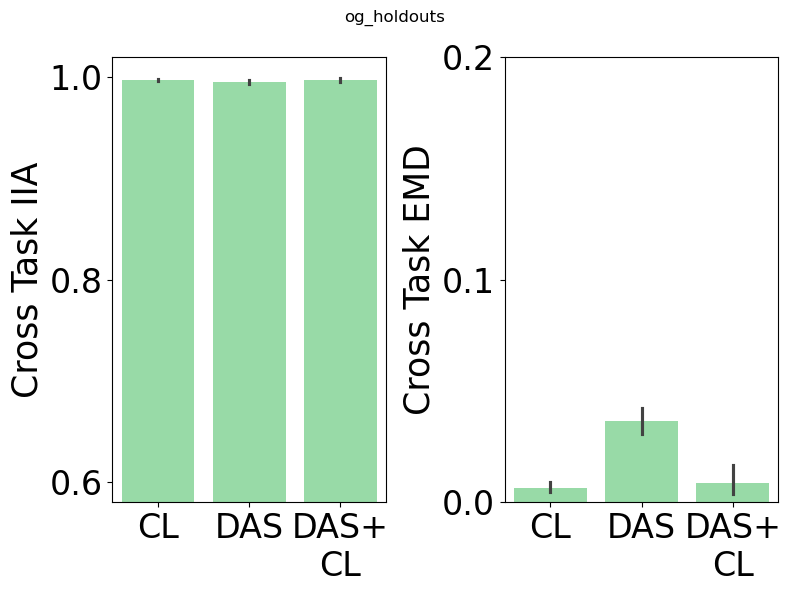

Starting Task og_noholdouts
Behavior Only Accuracy {False: np.float64(0.997000002861023)} +/- {False: np.float64(0.0012649183396490611)}
Behavior Only EMD {False: np.float64(0.0324420221149921)} +/- {False: np.float64(0.007057275548141364)}
og_noholdouts


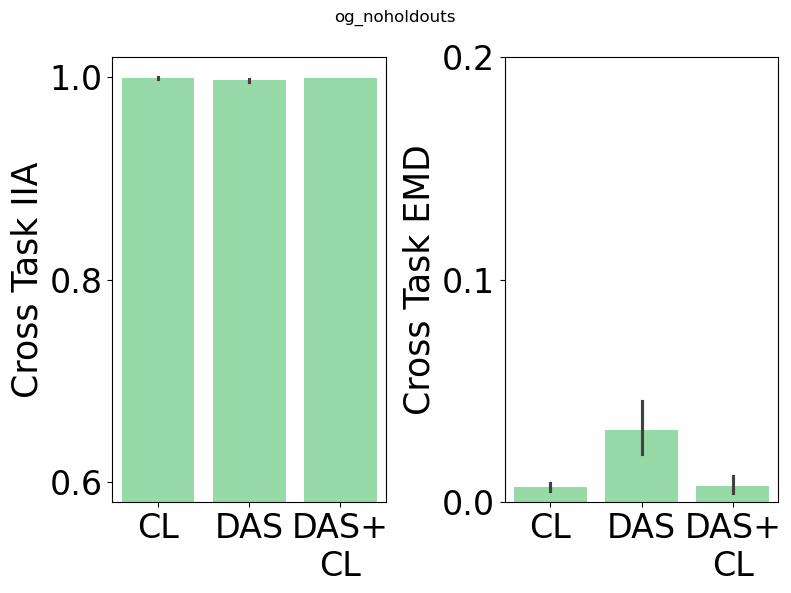

Starting Task xor
Behavior Only Accuracy {False: np.float64(0.9429999828338623)} +/- {False: np.float64(0.012708261819026238)}
Behavior Only EMD {False: np.float64(0.052857203781604724)} +/- {False: np.float64(0.008145667239358698)}
xor


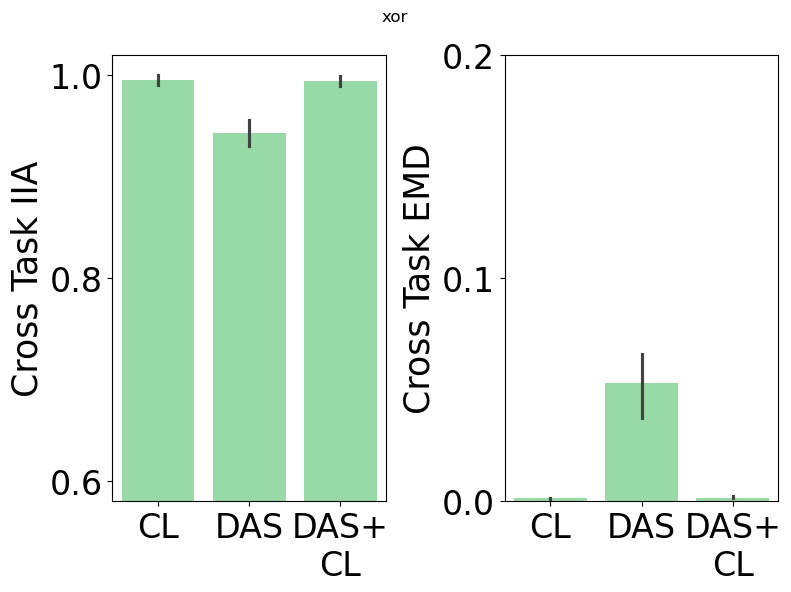

Starting Task inner_square
Behavior Only Accuracy {False: np.float64(0.939000004529953)} +/- {False: np.float64(0.015353248867243065)}
Behavior Only EMD {False: np.float64(0.13137363195419308)} +/- {False: np.float64(0.023426431792691136)}
inner_square
Saved to: figs/ood_inner_square_16d.png


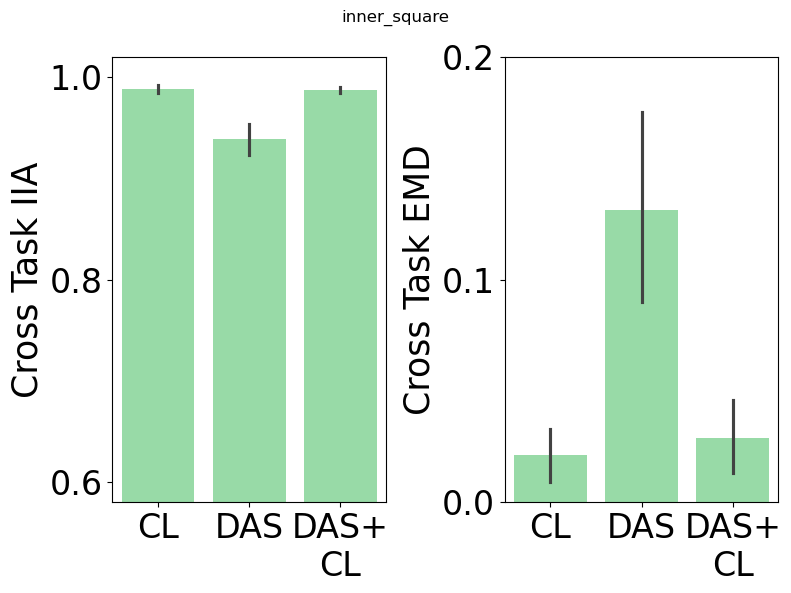

In [39]:
# Pick cases you want to plot
incl_filters = {
    #"mtx_type": ["orthog"],
    #"extra_dims": [64],
    "incl_extra": [False],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    "mask_dims": [1,],
    #"lr": [0.05],
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    # "task_division": ["inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0.95 # Ensures we're only looking at cases where classifiers were successful

rot = 35
ylim = [0.58,1.02]
x = "loss_type"
y = "cross_actn_acc"
hue = "incl_extra"
incl_legend = False
draw_baselines = False
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
labelsize = 25
ticksize = 24
fontsize = 30
titlesize = 25
legendsize = 20
linewidth = 4
err_alpha = 0.3
yticks = [0.6, 0.8, 1.0]


if hue=="task_spacing":
    p = {
        "Dense": sns.color_palette("pastel")[color_order[0]],
        "Sparse": sns.color_palette("pastel")[color_order[1]],
        "Original": sns.color_palette("pastel")[color_order[2]],
    }
    pp = {
        "Dense": sns.color_palette("bright")[color_order[0]],
        "Sparse": sns.color_palette("bright")[color_order[1]],
        "Original": sns.color_palette("pastel")[color_order[2]],
    }
else:
    p = {k: sns.color_palette("pastel")[color_order[i]] for i,k in enumerate(full_df[hue].unique())}
    pp = {k: sns.color_palette("bright")[color_order[i]] for i,k in enumerate(full_df[hue].unique())}
sort_map = {0:0,1:1}
for task in set(full_df["task_division"]):
    print("Starting Task", task)
    plot_df = full_df.copy()
    plot_df = plot_df.loc[plot_df["class_val_acc"]>class_acc_threshold]
    for filt,vals in incl_filters.items():
        plot_df = plot_df.loc[plot_df[filt].isin(vals)]
    for filt,vals in excl_filters.items():
        plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
    plot_df = plot_df.loc[plot_df["task_division"]==task]
    plot_df = plot_df.copy()
    if len(plot_df)<=0:
        print("No samples for task", task)
        continue
    
    bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
    plot_df.loc[bools,"cl_eps"] = 0
    
    # Pick out best CL epsilon
    group_cols = [
        "seed", "incl_extra", "extra_dims",
        "lr",  "mask_dims", "cl_1d", "loss_type",
        "cl_eps",
    ]
    dupl_cols = [gc for gc in group_cols if gc!="cl_eps"] + ["task_spacing",]
    plot_df["group_acc"] = plot_df.groupby(group_cols)["cross_actn_acc"].transform("mean")
    plot_df["group_emd"] = plot_df.groupby(group_cols)["cross_row_emd"].transform("mean")
    plot_df = plot_df.sort_values(by=["group_acc", "group_emd"], ascending=[False,True])\
        .drop_duplicates(dupl_cols)
    plot_df = plot_df.sort_values(by="loss_type")
    
    # Determine accuracy in absence of cl loss
    bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
    bloss_acc = dict(plot_df.loc[bools].groupby(hue)[y].mean())
    bloss_err = dict(plot_df.loc[bools].groupby(hue)[y].sem())
    bloss_emd = dict(plot_df.loc[bools].groupby(hue)["cross_row_emd"].mean())
    bloss_emr = dict(plot_df.loc[bools].groupby(hue)["cross_row_emd"].sem())
    print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)
    print("Behavior Only EMD", bloss_emd, "+/-", bloss_emr)
    
    fig,axes = plt.subplots(1,2,figsize=(8,6))
    
    print(task)
    ax = axes[0]
    plt.sca(ax)
    loss_types = {CL,CLDAS}
    if not draw_baselines:
        loss_types.add(DAS)
    temp_df = plot_df.loc[plot_df["loss_type"].isin(loss_types)]
    sns.barplot(x=x, y=y, hue=hue, data=temp_df, ax=ax, palette=p, errorbar="se")
    plt.title(f"", fontsize=titlesize)
    plt.ylim(ylim)
    plt.xlabel("", fontsize=labelsize)
    plt.ylabel("Cross Task IIA", fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(yticks,fontsize=ticksize)
    
    if draw_baselines:
        # Baseline
        xs = list(range(len(set(temp_df[x]))))
        xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
        xs = np.asarray(xs)
        for i,k in enumerate(bloss_acc):
            acc = bloss_acc[k]
            err = bloss_err[k]
            color = pp[k]
            ys = np.asarray([acc for _ in xs])
            plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
            plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
        
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize)
    if task!="inner_square" or not incl_legend:
        plt.legend().set_visible(False)
    
    # EMD
    ax = axes[1]
    plt.sca(ax)
    temp_df = plot_df.loc[plot_df["loss_type"].isin(loss_types)]
    sns.barplot(x="loss_type", y="cross_row_emd", hue=hue, data=temp_df, ax=ax, palette=p)
    plt.title(f"", fontsize=titlesize)
    plt.xlabel("", fontsize=labelsize)
    plt.ylabel("Cross Task EMD", fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks([0,0.10,0.20],fontsize=ticksize)
    
    if draw_baselines:
        # Baseline
        xs = list(range(len(set(temp_df[x]))))
        xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
        xs = np.asarray(xs)
        for i,k in enumerate(bloss_emd):
            acc = bloss_emd[k]
            err = bloss_emr[k]
            color = pp[k]
            ys = np.asarray([acc for _ in xs])
            plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
            plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
    
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize).set_visible(False)
    
    plt.suptitle(task)
    plt.tight_layout()
    extra_dims = "-".join([str(t) for t in temp_df["extra_dims"].unique()])
    if task=="inner_square":
        figname = f"figs/ood_inner_square_{extra_dims}d.png"
        plt.savefig(figname, dpi=600, bbox_inches="tight")
        print("Saved to:", figname)
    plt.show()

In [40]:
incl_filters = {
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    #"extra_dims": [64],
    "mask_dims": [1,],
    #"lr": [0.01],
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    # "task_division": ["original"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

groups = ["task_division", "loss_type",]
metrics = ["emd", "row_emd", "cross_emd", "cross_row_emd", "actn_acc", "cross_actn_acc",]
mtx_type = "orthog"

plot_df = full_df.copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()

temp = plot_df.groupby(groups)[metrics]\
    .agg(["mean", "sem"]).reset_index()
columns = []
for col in temp.columns:
    if type(col)==tuple:
        columns.append(f"{col[0]} {col[1]}".replace(" mean", "").strip())
    else:
        columns.append(col.strip())
temp.columns = columns
#temp.sort_values(by=["spacing_order", "cl_eps"], ascending=False)
temp.sort_values(by=groups)

,task_division,loss_type,emd,emd sem,row_emd,row_emd sem,cross_emd,cross_emd sem,cross_row_emd,cross_row_emd sem,actn_acc,actn_acc sem,cross_actn_acc,cross_actn_acc sem
0,inner_square,CL,4.003031,0.100303,0.006882,0.001815,4.023161,0.098476,0.020989,0.006462,0.996750,0.001121,0.988750,0.003731
1,inner_square,DAS,6.147012,0.727870,0.133739,0.038974,5.836769,0.515312,0.131374,0.023426,0.999500,0.000500,0.939000,0.015353
2,inner_square,DAS+\nCL,4.018512,0.099537,0.007035,0.001353,4.045253,0.104487,0.028760,0.008965,0.998250,0.000651,0.987250,0.003015
3,og_holdouts,CL,3.737295,0.035681,0.006582,0.001198,3.737164,0.035019,0.006681,0.000957,0.998750,0.000618,0.998750,0.000527
4,og_holdouts,DAS,4.248197,0.051064,0.029818,0.003049,4.283232,0.071341,0.031714,0.003085,1.000000,0.000000,0.997375,0.001078
5,og_holdouts,DAS+\nCL,3.733664,0.036136,0.006934,0.002081,3.736485,0.035349,0.007564,0.002083,0.998875,0.000435,0.998750,0.000874
6,og_noholdouts,CL,3.639899,0.027577,0.006644,0.000959,3.639391,0.026454,0.006657,0.000962,0.999800,0.000200,0.999700,0.000300
7,og_noholdouts,DAS,4.012311,0.091314,0.036023,0.004171,4.002925,0.100147,0.036435,0.004701,1.000000,0.000000,0.996900,0.000795
8,og_noholdouts,DAS+\nCL,3.635139,0.026100,0.006595,0.000866,3.634890,0.025710,0.006552,0.001147,0.999900,0.000100,0.999700,0.000213
9,xor,CL,3.667155,0.100577,0.000822,0.000045,3.670927,0.099866,0.001229,0.000107,0.997500,0.002007,0.997500,0.002500


In [41]:
csv_id

### Correlating high EMD with high IIA
We can run a linear regression over trainings exploring the question of whether divergence is anti-correlated with interchange accuracy.

In [42]:
from scipy import stats

def regress(x,y):
    """
    How to use:
    > x = np.random.randn(100)
    > f = lambda x: 2*x+1
    > y = f(x)
    > slope, intercept, pvalue, rvalue = regress(x,y)   # 2, 1, 0, 1
    """
    m = stats.linregress(x.squeeze(),y)
    return m.slope, m.intercept, m.pvalue, m.rvalue**2


In [43]:
# Pick cases you want to plot
incl_filters = {
    # "extra_dims": [64], # 16,],
    "incl_extra": [False],
    "mask_dims": [1,],
    "task_division": ["original", "og_holdouts", "inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0

x_axis = "mask_dims"
hue = "loss_type"
col = "lr"
row = "extra_dims"


plot_df = full_df.copy()
plot_df = plot_df.loc[plot_df["class_val_acc"]>class_acc_threshold]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]

bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
plot_df.loc[bools,"cl_eps"] = 0

lin_regs = {
    x_axis: [],
    hue: [],
    col: [],
    row: [],
    "emd_type": [],
    "coef": [],
    "intercept": [],
    "pvalue": [],
    "rvalue": [],
}
params = []
pvals = []

temp_df = plot_df.copy()
for xx in set(temp_df[x_axis]):
    ttemp = temp_df.loc[temp_df[x_axis]==xx]
    for hhue in set(ttemp[hue]):
        tttemp = ttemp.loc[ttemp[hue]==hhue]
        if len(tttemp)==0: continue
        for c in set(tttemp[col]):
            tttt = tttemp.loc[tttemp[col]==c]
            if len(tttt)==0: continue
            for r in set(tttt[row]):
                t = tttt.loc[tttt[row]==r]
                if len(t)==0: continue
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
df = pd.DataFrame(lin_regs)
df

,mask_dims,loss_type,lr,extra_dims,emd_type,coef,intercept,pvalue,rvalue
0,1,DAS,0.01,16,cross,-0.025150,1.095448,5.991591e-05,0.600661
1,1,DAS,0.01,16,within,-0.018377,1.063705,9.448166e-05,0.580607
2,1,DAS,0.01,16,row_cross,-0.580171,1.015497,1.293879e-09,0.876719
3,1,DAS,0.01,16,row_within,-0.377401,0.999051,3.011619e-06,0.711229
4,1,CL,0.01,16,cross,-0.007789,1.023973,3.559601e-01,0.047501
5,1,CL,0.01,16,within,-0.014240,1.048863,8.414722e-02,0.156600
6,1,CL,0.01,16,row_cross,-0.148607,0.995806,2.962415e-01,0.060409
7,1,CL,0.01,16,row_within,-1.154489,1.001522,9.395140e-03,0.319539
8,1,DAS+\nCL,0.01,16,cross,-0.017651,1.061676,9.845210e-03,0.316294
9,1,DAS+\nCL,0.01,16,within,-0.012376,1.040972,1.041204e-01,0.139992


In [44]:
for emd_type in ["cross_emd", "emd", "cross_row_emd", "row_emd"]:
    coef,intercept,pvalue,rvalue = regress(np.asarray(plot_df[emd_type])[:,None], np.asarray(plot_df["cross_actn_acc"]))
    print("EMD Type:", emd_type)
    print("\tCoef:", coef)
    print("\tIntrc:", intercept)
    print("\tpvalue:", pvalue)
    print("\trvalue:", rvalue)

EMD Type: cross_emd
	Coef: -0.023349715806030256
	Intrc: 1.084846146828367
	pvalue: 4.50964742124924e-14
	rvalue: 0.6281984824373105
EMD Type: emd
	Coef: -0.018386251663537818
	Intrc: 1.0643088318877862
	pvalue: 7.906282348873758e-14
	rvalue: 0.621001754155773
EMD Type: cross_row_emd
	Coef: -0.4767814288369388
	Intrc: 1.0030238362985235
	pvalue: 9.778165739413528e-21
	rvalue: 0.7801788085660675
EMD Type: row_emd
	Coef: -0.366864025943351
	Intrc: 0.9966570227900148
	pvalue: 1.4619594679573846e-17
	rvalue: 0.7175498440363307


## Hyperparameter Search

In [45]:
import time
from toytask_utils import all_divisions
from datetime import datetime

csv_id = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(csv_id)


data_params = {
    "extra_dims": 128,
    "dupl_rank": 0, # duplicates extra dims
    "zero_rank": 0, # zeros out extra dims in a rotated space
    "cov_strength": 0, # how much do the extraneous dimensions covary with the x and y values,
    "n_samples_per_class": 100,
    "mask_dims": 1,
}

mlp_params = {
    "lr": 0.01,
    "patience": 100,
    "l2": 0.005,
    "bsize": 200,
    "patience": 100,
    "n_epochs": 1000,
    "drop_p": 0.5,
    "hidden_dim": 128,
    "n_layers": 2, # 1-3 layers
    "pre_batchnorm": True,
    "batchnorm": True,
    "ret_best": True,
    "epoch_prog": True,
}


divisions = [ "inner_square", "original" ]
combine_classifiers = False
mtx_types = ["linear",] # "orthogonal"]
cl_epses = [1, 10, 50, 100]
lrs = [0.05, 0.025, 0.01, 0.005] #, 0.1, 0.01, 0.005]
extra_dims_list = [0,16,64]
incl_extras = [False] # determines if extraneous subspace should be included in cl loss
mask_dims = [1,4,8]
do_normalize = False
actn_losses = [False, True]
n_repeats = 3
verbose = False


search_cols = ["task_division", "mtx_type", "cl_eps", "lr", "extra_dims", "incl_extras", "mask_dims", "seed"]

ylim = [-2.75, 1.75]

exp_params = {
    "n_epochs": 3000,
    "lr": 0.025,
    "cl_eps": 100,
    "shuffle_empty": False,
    "method": "mean",
    "incl_extra": False,
    "calc_loss_in_aligned_basis": False,
    "detach_cl_vecs": True,
    "cl_1d": True,
    "mtx_type": "orthog",
    "cl_loss_type": "both",
    "early_stop_patience": 500,
}



dfs = []
all_keys = {*set(data_params.keys()), *set(mlp_params.keys()), *set(exp_params.keys())}
save_keys = ["incl_extra", "extra_dims", "lr", "incl_actn_loss", "incl_cl_loss", "cl_eps", "mask_dims"]
excl_keys = [key for key in all_keys if key not in save_keys]
classifier_dict = dict()
for incl_extra in incl_extras:
    exp_params["incl_extra"] = incl_extra
    for mask_dim in mask_dims:
        for repeat in range(n_repeats):
            seed = int(str(repeat+1)*5)
            for extra_dims in extra_dims_list:
                data_params["extra_dims"] = extra_dims
                for lr in lrs:
                    exp_params["lr"] = lr
                    for ial,incl_actn_loss in enumerate(actn_losses):
                        for icl,incl_cl_loss in enumerate([False, True,]):
                            if not incl_actn_loss and not incl_cl_loss: continue
                            for ice, cl_eps in enumerate(cl_epses):
                                exp_params["cl_eps"] = cl_eps
                                if ice > 0 and not incl_cl_loss: continue
                                d = data_params["extra_dims"]+2
                                if mask_dim*2 > d: continue
                                data_params["mask_dims"] = mask_dim
                                if incl_cl_loss: use_best = "by_emd"
                                elif incl_actn_loss: use_best = "by_acc"
                                df_dict = {
                                    "run_id": [],
                                    "seed": [],
                                    "task_num": [],
                                    "task_division": [],
                                    "n_samples": [],
                                    "min_class_count": [],
                                    "max_class_count": [],
                                    "mean_class_count": [],
                                    "class_trn_acc": [],
                                    "class_val_acc": [],
                                    "cl_loss": [],
                                    "actn_loss": [],
                                    "actn_acc": [],
                                    "emd": [],
                                    "row_emd": [],
                                    "cross_cl_loss": [],
                                    "cross_actn_loss": [],
                                    "cross_actn_acc": [],
                                    "cross_emd": [],
                                    "cross_row_emd": [],
                                    "mtx_type": [],
                                }

                                exp_params["incl_cl_loss"] = incl_cl_loss
                                exp_params["incl_actn_loss"] = incl_actn_loss

                                for tdi,task_division in enumerate(divisions):
                                    if task_division in excl_divisions:
                                        print("Skipping", task_division)
                                        continue
                                    print("Starting Task Division", task_division)

                                    np.random.seed(seed)
                                    torch.manual_seed(seed)

                                    for _ in mtx_types:
                                        df_dict["task_division"].append(task_division)
                                        df_dict["task_division"].append(task_division)
                                        df_dict["task_num"].append(0)
                                        df_dict["task_num"].append(1)
                                    tdict = make_tasks(task_division=task_division, varbs=og_varbs)
                                    task1_bools, task2_bools = tdict["bools"]
                                    task1_tups, task2_tups = tdict["tups"]

                                    ##########################################################################
                                    ### DATA PREP
                                    ##########################################################################
                                    comb_class = combine_classifiers
                                    if type(comb_class)==dict:
                                        if task_division in comb_class:
                                            comb_class = comb_class[task_division]
                                        else:
                                            comb_class = combine_classifiers.get("default", True)
                                    if comb_class:
                                        excl_tups1 = set(task2_tups)-set(task1_tups)
                                        excl_tups2 = set(task1_tups)-set(task2_tups)
                                        print("Excl1:", excl_tups1)
                                        print("Excl2:", excl_tups2)
                                    else:
                                        excl_tups1 = None
                                        excl_tups2 = None
                                    exp_params["distinct_classifiers"] = not comb_class

                                    vbs1 = og_varbs[task1_bools]
                                    smp1 = samples[task1_bools]
                                    len1 = len(vbs1)
                                    vbs2 = og_varbs[task2_bools]
                                    smp2 = samples[task2_bools]
                                    len2 = len(vbs2)

                                    data_dict = prep_data(
                                        og_varbs=vbs1,
                                        samples=smp1,
                                        **data_params,
                                        excl_tups=excl_tups1,
                                    )

                                    if valids.sum() == 0:
                                        print("No valid intrvs")
                                        continue
                                    valids = data_dict["valid_intrvs"]
                                    src = data_dict["src_vecs"][valids]
                                    trg = data_dict["trg_vecs"][valids]
                                    task1_data = {
                                        "src_vecs": src,
                                        "trg_vecs": trg,
                                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                                        "intrv_classes": data_dict["intrv_classes"][valids],
                                        "src_varbs": data_dict["src_varbs"][valids],
                                        "src_classes": data_dict["src_classes"][valids],
                                    }
                                    counts = []
                                    intrv_classes = data_dict["intrv_classes"][valids]
                                    for c in sorted(set(intrv_classes.cpu().tolist())):
                                        counts.append((intrv_classes==c).long().sum().item())
                                    for _ in mtx_types:
                                        df_dict["n_samples"].append(len(intrv_classes))
                                        df_dict["min_class_count"].append(np.min(counts))
                                        df_dict["max_class_count"].append(np.max(counts))
                                        df_dict["mean_class_count"].append(np.mean(counts))
                                    print("Class Distr 1:",
                                          "\n\tMin:", df_dict["min_class_count"][-1],
                                          "\n\tMax:", df_dict["max_class_count"][-1],
                                          "\n\tMean:", df_dict["mean_class_count"][-1],
                                        )
                                    print("\tSrc   Classes:", set([int(c) for c in data_dict["src_classes"]]))
                                    print("\tIntrv Classes:", set([int(c) for c in data_dict["intrv_classes"]]))

                                    v2class = None
                                    if comb_class:
                                        v2class = data_dict["v2class"]

                                    data_dict = prep_data(
                                        og_varbs=vbs2,
                                        samples=smp2,
                                        **data_params,
                                        v2class=v2class,
                                        excl_tups=excl_tups2,
                                    )

                                    valids = data_dict["valid_intrvs"]
                                    src = data_dict["src_vecs"][valids]
                                    trg = data_dict["trg_vecs"][valids]
                                    task2_data = {
                                        "src_vecs": src,
                                        "trg_vecs": trg,
                                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                                        "intrv_classes": data_dict["intrv_classes"][valids],
                                        "src_varbs": data_dict["src_varbs"][valids],
                                        "src_classes": data_dict["src_classes"][valids],
                                    }
                                    counts = []
                                    intrv_classes = data_dict["intrv_classes"]
                                    for c in sorted(set(intrv_classes.cpu().tolist())):
                                        counts.append((intrv_classes==c).long().sum().item())
                                    for _ in mtx_types:
                                        df_dict["n_samples"].append(len(intrv_classes))
                                        df_dict["min_class_count"].append(np.min(counts))
                                        df_dict["max_class_count"].append(np.max(counts))
                                        df_dict["mean_class_count"].append(np.mean(counts))
                                    print("Class Distr 2:",
                                          "\n\tMin:", df_dict["min_class_count"][-1],
                                          "\n\tMax:", df_dict["max_class_count"][-1],
                                          "\n\tMean:", df_dict["mean_class_count"][-1],
                                        )
                                    print("\tSrc   Classes:", set([int(c) for c in data_dict["src_classes"]]))
                                    print("\tIntrv Classes:", set([int(c) for c in data_dict["intrv_classes"]]))

                                    if verbose:
                                        print(task_division)
                                        quick_plot(
                                            task1_data["src_vecs"], task2_data["src_vecs"],
                                            natty_classes=task1_data["src_classes"],
                                            intrv_classes=task2_data["src_classes"],
                                            #labels=["Task1", "Task2"],
                                            incl_legend=True,
                                            incl_dividers=False,
                                            ylim=ylim,
                                        )

                                    ##########################################################################
                                    data_id = "_".join([f"{k}{v}" for k,v in data_params.items()])
                                    mlp_id = "_".join([f"{k}{v}" for k,v in mlp_params.items()])
                                    ##########################################################################
                                    ### Classifier Training
                                    ##########################################################################
                                    if verbose:
                                        print()
                                        print("Task Data:", len(task1_data["src_vecs"]))
                                        print("\t", len(task1_data["src_classes"]))
                                        print("mlp_params:", mlp_params)
                                        print()

                                    if comb_class:
                                        print("Combining classifiers into single classifier")
                                        class_data = {
                                            "src_vecs": torch.cat([task1_data["src_vecs"], task2_data["src_vecs"]]),
                                            "src_classes": torch.cat([task1_data["src_classes"], task2_data["src_classes"]]),
                                        }
                                    else:
                                        class_data = task1_data

                                    print("Training Classifier1")
                                    train_id = data_id + "_" + mlp_id + f"combo{comb_class}_seed{seed}_{task_division}1"
                                    if train_id in classifier_dict:
                                        classifier1, trn_acc, val_acc = classifier_dict[train_id]
                                    else:
                                        classifier1, trn_acc, val_acc = train_classifier(
                                            vecs=class_data["src_vecs"],
                                            classes=class_data["src_classes"],
                                            **mlp_params,
                                            verbose=verbose,
                                        )
                                        classifier_dict[train_id] = (classifier1, trn_acc, val_acc)
                                    classifier1.cuda()
                                    classifier1.eval()
                                    for p in classifier1.parameters():
                                        p.requires_grad = False
                                    for _ in mtx_types:
                                        df_dict["class_trn_acc"].append(trn_acc)
                                        df_dict["class_val_acc"].append(val_acc)

                                    if comb_class:
                                        classifier2 = classifier1
                                    else:
                                        print("Training Classifier2")
                                        train_id = data_id + "_" + mlp_id + f"combo{comb_class}_seed{seed}_{task_division}2"
                                        if train_id in classifier_dict:
                                            classifier2, trn_acc, val_acc = classifier_dict[train_id]
                                        else:
                                            classifier2, trn_acc, val_acc = train_classifier(
                                                vecs=task2_data["src_vecs"],
                                                classes=task2_data["src_classes"],
                                                **mlp_params,
                                                verbose=verbose,
                                            )
                                            classifier_dict[train_id] = (classifier2, trn_acc, val_acc)
                                        classifier2.cuda()
                                        classifier2.eval()
                                        for p in classifier2.parameters():
                                            p.requires_grad = False
                                    for _ in mtx_types:
                                        df_dict["class_trn_acc"].append(trn_acc)
                                        df_dict["class_val_acc"].append(val_acc)

                                    mask = data_dict["mask"]

                                    ##########################################################################
                                    ### Rotation Matrix Training
                                    ##########################################################################
                                    for mtx_type in mtx_types:
                                        print("--------------------")
                                        print("Performing New Training")
                                        for k in sorted(save_keys):
                                            if k in exp_params: v = exp_params[k]
                                            elif k in data_params: v = data_params[k]
                                            elif k in mlp_params: v = mlp_params[k]
                                            print(k,v)
                                        print()

                                        important_keys = ["cl_loss", "actn_loss", "acc", "emd", "row_emd"]

                                        exp_params["mtx_type"] = mtx_type
                                        run_id = time.time()
                                        df_dict["run_id"].append(run_id)
                                        df_dict["run_id"].append(run_id)
                                        df_dict["seed"].append(seed)
                                        df_dict["seed"].append(seed)
                                        df_dict["mtx_type"].append(mtx_type)
                                        df_dict["mtx_type"].append(mtx_type)
                                        print("Training Task1 Matrix", mtx_type)
                                        ret_dict1 = train_rotation(
                                            **task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            print_every=200,
                                            fig_every=np.inf,
                                            early_stopping=True,
                                            verbose=verbose,
                                        )
                                        rd = ret_dict1
                                        best_dict = rd["best_metrics"]
                                        rm = rd["last_mtx"]
                                        if use_best=="by_acc":
                                            rm = best_dict["mtx"]
                                        elif use_best=="by_loss":
                                            rm = rd["bestloss_metrics"]["mtx"]
                                            best_dict = rd["bestloss_metrics"]
                                        elif use_best=="by_emd":
                                            rm = rd["bestemd_metrics"]["mtx"]
                                            best_dict = rd["bestemd_metrics"]
                                        task1_rot_mtx = rm
                                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                                        print("End Task1 Training")
                                        print()
                                        df_dict["cl_loss"].append(float(cl_loss))
                                        df_dict["actn_loss"].append(float(actn_loss))
                                        df_dict["actn_acc"].append(float(acc))
                                        df_dict["emd"].append(float(emd))
                                        df_dict["row_emd"].append(float(row_emd))


                                        print("Training Task2 Matrix")
                                        ret_dict2 = train_rotation(
                                            **task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            print_every=200,
                                            fig_every=np.inf,
                                            early_stopping=True,
                                            verbose=verbose,
                                        )
                                        rd = ret_dict2
                                        best_dict = rd["best_metrics"]
                                        rm = rd["last_mtx"]
                                        if use_best=="by_acc":
                                            rm = best_dict["mtx"]
                                        elif use_best=="by_loss":
                                            rm = rd["bestloss_metrics"]["mtx"]
                                            best_dict = rd["bestloss_metrics"]
                                        elif use_best=="by_emd":
                                            rm = rd["bestemd_metrics"]["mtx"]
                                            best_dict = rd["bestemd_metrics"]
                                        task2_rot_mtx = rm
                                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                                        print("End Task2 Training")
                                        print()
                                        df_dict["cl_loss"].append(float(cl_loss))
                                        df_dict["actn_loss"].append(float(actn_loss))
                                        df_dict["actn_acc"].append(float(acc))
                                        df_dict["emd"].append(float(emd))
                                        df_dict["row_emd"].append(float(row_emd))


                                        ##########################################################################
                                        ### Testing
                                        ##########################################################################
                                        save_params = {**data_params, **exp_params}
                                        for k in list(save_params.keys()):
                                            if k in excl_keys: del save_params[k]
                                        save_params["task"] = 1
                                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                                        if verbose:
                                            print("Testing Task1 Matrix on Task1 Data")
                                            cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                                task1_rot_mtx,
                                                task1_data,
                                                classifier=classifier1,
                                                mask=mask,
                                                **exp_params,
                                                ylim=ylim,
                                                fig_save_name=save_name,
                                                verbose=verbose,
                                            )
                                        print("Testing Task1 Matrix on Task2 Data")
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task1_rot_mtx,
                                            task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                            verbose=verbose,
                                        )
                                        df_dict["cross_cl_loss"].append(float(cl_loss))
                                        df_dict["cross_actn_loss"].append(float(actn_loss))
                                        df_dict["cross_actn_acc"].append(float(acc))
                                        df_dict["cross_emd"].append(float(emd))
                                        df_dict["cross_row_emd"].append(float(row_emd))

                                        if verbose:
                                            print("Testing Task2 Matrix on Task2 Data")
                                            cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                                task2_rot_mtx,
                                                task2_data,
                                                classifier=classifier2,
                                                mask=mask,
                                                **exp_params,
                                                ylim=ylim,
                                                fig_save_name=save_name,
                                                verbose=verbose,
                                            )
                                        print("Testing Task2 Matrix on Task1 Data")
                                        save_params["task"] = 2
                                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task2_rot_mtx,
                                            task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                            verbose=verbose,
                                        )
                                        df_dict["cross_cl_loss"].append(float(cl_loss))
                                        df_dict["cross_actn_loss"].append(float(actn_loss))
                                        df_dict["cross_actn_acc"].append(float(acc))
                                        df_dict["cross_emd"].append(float(emd))
                                        df_dict["cross_row_emd"].append(float(row_emd))

                                        classifier1.cpu()
                                        classifier2.cpu()
                                        print("-"*100)
                                        print()
                                        print()
                                        print()
                                        print()
                                        print()
                                df = pd.DataFrame(df_dict)
                                for k in exp_params:
                                    if k!="mtx_type":
                                        df[k] = exp_params[k]
                                for k in data_params:
                                    df[k] = data_params[k]
                                dfs.append(df)
                            full_df = pd.concat(dfs)
                            full_df.to_csv(f"csvs/cl_ablations_{csv_id}.csv", header=True, index=False)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3120039935.py, line 39)

In [46]:
csv_id = None

In [47]:
if csv_id is None:
    full_df = pd.read_csv("csvs/cl_synthetic_ablations.csv")
else:
    full_df = pd.read_csv(f"csvs/cl_ablations_{csv_id}.csv")
full_df

,run_id,seed,task_num,task_division,n_samples,min_class_count,max_class_count,mean_class_count,class_trn_acc,class_val_acc,cl_loss,actn_loss,actn_acc,emd,row_emd,cross_cl_loss,cross_actn_loss,cross_actn_acc,cross_emd,cross_row_emd,mtx_type,n_epochs,lr,cl_eps,shuffle_empty,method,incl_extra,calc_loss_in_aligned_basis,detach_cl_vecs,cl_1d,cl_loss_type,early_stop_patience,incl_cl_loss,incl_actn_loss,extra_dims,dupl_rank,zero_rank,cov_strength,n_samples_per_class,mask_dims
0,1.763511e+09,11111,0,inner_square,400,100,100,100.0,1.0,1.0,0.005698,0.316251,1.00000,0.005440,0.005440,0.016353,0.372644,1.00000,0.001988,0.001988,linear,3000,0.050,1,False,mean,False,False,True,True,both,400,True,False,0,0,0,0,100,1
1,1.763511e+09,11111,1,inner_square,400,100,100,100.0,1.0,1.0,0.215093,0.371552,1.00000,0.002342,0.002342,0.014532,0.317524,1.00000,0.005320,0.005320,linear,3000,0.050,1,False,mean,False,False,True,True,both,400,True,False,0,0,0,0,100,1
2,1.763511e+09,11111,0,original,800,100,100,100.0,1.0,1.0,0.130874,0.069847,1.00000,0.010960,0.010960,0.014857,0.070357,1.00000,0.008131,0.008131,linear,3000,0.050,1,False,mean,False,False,True,True,both,400,True,False,0,0,0,0,100,1
3,1.763511e+09,11111,1,original,800,100,100,100.0,1.0,1.0,0.005550,0.070837,1.00000,0.005962,0.005962,0.014401,0.069723,1.00000,0.011399,0.011399,linear,3000,0.050,1,False,mean,False,False,True,True,both,400,True,False,0,0,0,0,100,1
4,1.763511e+09,11111,0,inner_square,400,100,100,100.0,1.0,1.0,0.005644,0.315089,1.00000,0.005628,0.005628,0.114096,0.392831,1.00000,0.061346,0.061346,linear,3000,0.050,10,False,mean,False,False,True,True,both,400,True,False,0,0,0,0,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,1.763545e+09,33333,1,original,800,100,100,100.0,1.0,1.0,0.749468,6.324984,0.21125,30.206165,0.843376,0.990825,6.264317,0.23250,31.133078,1.032782,linear,3000,0.005,50,False,mean,False,False,True,True,both,400,True,True,64,0,0,0,100,4
1616,1.763545e+09,33333,0,inner_square,400,100,100,100.0,1.0,1.0,0.717837,2.830818,0.44500,34.827858,1.841351,0.867961,4.952121,0.38750,32.366318,1.726940,linear,3000,0.005,100,False,mean,False,False,True,True,both,400,True,True,64,0,0,0,100,4
1617,1.763545e+09,33333,1,inner_square,400,100,100,100.0,1.0,1.0,0.228480,2.187158,0.49250,95.859665,0.999810,1.082127,2.855776,0.51250,110.034546,1.077722,linear,3000,0.005,100,False,mean,False,False,True,True,both,400,True,True,64,0,0,0,100,4
1618,1.763545e+09,33333,0,original,800,100,100,100.0,1.0,1.0,0.221236,4.927679,0.26625,133.436066,0.776659,0.598955,5.587847,0.23750,140.346786,0.857702,linear,3000,0.005,100,False,mean,False,False,True,True,both,400,True,True,64,0,0,0,100,4


In [48]:
CL = "CL"
CLDAS = "DAS+\nCL"
DAS = "DAS"
loss_map = {
    (False,True): CL,
    (True,True): CLDAS,
    (True,False): DAS,
}
full_df["loss_type"] = full_df.apply(lambda x: loss_map[(x.incl_actn_loss, x.incl_cl_loss)], axis=1)

In [49]:
search_cols = [
    "loss_type", "task_division",
    "mtx_type", "cl_eps", "lr", "extra_dims", "incl_extra", "mask_dims"
]
cols = [
    "run_id",
    "task_num", "task_division", "mtx_type", "loss_type", "cl_eps",
    "min_class_count", "max_class_count", "mean_class_count",
    "actn_acc", "cross_actn_acc",
    "emd", "cross_emd",
    "row_emd", "cross_row_emd",
]
# exp_keys = list(exp_params.keys())
# df = pd.merge(left=full_df, right=counts_df, on=["task_num", "task_division"]+exp_keys) 
# df.sort_values(by=["task_division", "task_num", "cross_actn_acc"], ascending=False)[cols]

#full_df.sort_values(by=["task_division", "task_num", "cross_actn_acc"], ascending=False)[cols]
metric_cols = [
    "actn_acc", "cross_actn_acc",
    "emd", "cross_emd",
    "row_emd", "cross_row_emd",
]
full_df.groupby(search_cols)[metric_cols].agg("mean")

actn_acc  cross_actn_acc         emd   cross_emd   row_emd  cross_row_emd
loss_type task_division mtx_type cl_eps lr    extra_dims incl_extra mask_dims                                                                           
CL        inner_square  linear   1      0.005 0          False      1          0.985417        0.990833    0.015719    0.019346  0.015719       0.019346
                                              16         False      1          0.997500        0.984583    4.048924    4.063861  0.011519       0.024395
                                                                    4          0.474583        0.475000   28.998379   32.003599  0.372329       0.379156
                                              64         False      1          0.982500        0.960000   19.500382   19.522079  0.009923       0.030990
                                                                    4          0.419167        0.453333  124.716983  123.766339  1.769854       1.868201
                                        0.010 0          False      1          0.996250        0.990417    0.014837    0.022722  0.014837       0.022722
                                              16         False      1          0.997500        0.988333    4.046067    4.062147  0.009914       0.022175
                                                                    4          0.470000        0.487500   43.818965   47.089267  0.220958       0.232616
                                              64         False      1          0.982500        0.968333   19.524724   19.543608  0.009003       0.027292
                                                                    4          0.411250        0.475417  147.089911  148.831144  1.177705       1.209345
                                        0.050 0          False      1          1.000000        0.997083    0.007289    0.006719  0.007289       0.006719
                                              16         False      1          0.997917        0.992500    4.045346    4.052356  0.008197       0.017391
                                                                    4          0.480833        0.490833   43.463592   49.522223  0.083838       0.103290
                                              64         False      1          0.976667        0.966250   19.517992   19.545937  0.010760       0.026860
                                                                    4          0.460417        0.473750   53.092483   57.347048  0.308709       0.562886
                                 10     0.005 0          False      1          0.985417        0.990833    0.015719    0.019346  0.015719       0.019346
                                              16         False      1          0.997500        0.984583    4.048924    4.063860  0.011519       0.024395
                                                                    4          0.475000        0.475000   28.996351   31.987095  0.372375       0.379215
                                              64         False      1          0.982500        0.960000   19.500398   19.522092  0.009923       0.030997
                                                                    4          0.411250        0.449583  124.676657  123.030219  1.774844       1.873926
                                        0.010 0          False      1          0.996250        0.990417    0.014837    0.022723  0.014837       0.022723
                                              16         False      1          0.997500        0.988333    4.046061    4.062148  0.009914       0.022183
                                                                    4          0.472083        0.487083   43.494343   46.639181  0.222004       0.233846
                                              64         False      1          0.981250        0.962500   19.511991   19.528600  0.009204       0.028731
                                                                    4          0.412083        0.4691

In [50]:
sort_map = {
    "Original": 0,
    "Dense": 1,
    "Sparse": 2,
}

In [51]:
full_df["train_type"] = full_df.apply(
    lambda x: f"{x.mtx_type}{x.incl_cl_loss*'_cl'}{x.incl_actn_loss*'_actn'}_{x.cl_eps}",
    axis=1)
full_df["task_spacing"] = "Original"
full_df.loc[(full_df["task_num"]==0)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Sparse"
full_df.loc[(full_df["task_num"]==1)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Dense"
full_df["spacing_order"] = full_df.apply(lambda x: sort_map[x.task_spacing], axis=1)
full_df.loc[~full_df["incl_cl_loss"]&full_df["incl_actn_loss"], "cl_eps"] = 0

In [52]:
full_df.loc[full_df["incl_actn_loss"]&~full_df["incl_cl_loss"]].head(10)

,run_id,seed,task_num,task_division,n_samples,min_class_count,max_class_count,mean_class_count,class_trn_acc,class_val_acc,cl_loss,actn_loss,actn_acc,emd,row_emd,cross_cl_loss,cross_actn_loss,cross_actn_acc,cross_emd,cross_row_emd,mtx_type,n_epochs,lr,cl_eps,shuffle_empty,method,incl_extra,calc_loss_in_aligned_basis,detach_cl_vecs,cl_1d,cl_loss_type,early_stop_patience,incl_cl_loss,incl_actn_loss,extra_dims,dupl_rank,zero_rank,cov_strength,n_samples_per_class,mask_dims,loss_type,train_type,task_spacing,spacing_order
16,1.763511e+09,11111,0,inner_square,400,100,100,100.0,1.0,1.0,0.006378,0.314145,1.00000,0.008670,0.008670,0.089683,0.386072,1.00000,0.046719,0.046719,linear,3000,0.050,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Sparse,2
17,1.763511e+09,11111,1,inner_square,400,100,100,100.0,1.0,1.0,0.258167,0.391101,1.00000,0.057408,0.057408,0.326757,0.470058,0.80250,0.190816,0.190816,linear,3000,0.050,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Dense,1
18,1.763511e+09,11111,0,original,800,100,100,100.0,1.0,1.0,0.138325,0.097207,1.00000,0.041962,0.041962,0.079060,0.111207,1.00000,0.035959,0.035959,linear,3000,0.050,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Original,0
19,1.763511e+09,11111,1,original,800,100,100,100.0,1.0,1.0,0.022796,0.126894,1.00000,0.047520,0.047520,0.080918,0.100102,0.99875,0.042328,0.042328,linear,3000,0.050,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Original,0
52,1.763512e+09,11111,0,inner_square,400,100,100,100.0,1.0,1.0,0.018421,0.328206,1.00000,0.047405,0.047405,0.016439,0.372997,1.00000,0.001971,0.001971,linear,3000,0.010,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Sparse,2
53,1.763512e+09,11111,1,inner_square,400,100,100,100.0,1.0,1.0,0.257310,0.396390,1.00000,0.070370,0.070370,0.862326,0.693159,0.73750,0.466217,0.466217,linear,3000,0.010,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Dense,1
54,1.763512e+09,11111,0,original,800,100,100,100.0,1.0,1.0,0.131817,0.105141,0.99875,0.042879,0.042879,0.097376,0.125961,1.00000,0.045978,0.045978,linear,3000,0.010,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Original,0
55,1.763512e+09,11111,1,original,800,100,100,100.0,1.0,1.0,0.023680,0.133267,1.00000,0.050477,0.050477,0.090648,0.110659,0.99750,0.045573,0.045573,linear,3000,0.010,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Original,0
88,1.763512e+09,11111,0,inner_square,400,100,100,100.0,1.0,1.0,0.030269,0.343787,1.00000,0.086934,0.086934,0.023717,0.378367,0.99750,0.004765,0.004765,linear,3000,0.005,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Sparse,2
89,1.763512e+09,11111,1,inner_square,400,100,100,100.0,1.0,1.0,0.263848,0.398691,1.00000,0.075166,0.075166,0.990123,0.743464,0.73750,0.521732,0.521732,linear,3000,0.005,0,False,mean,False,False,True,True,both,400,False,True,0,0,0,0,100,1,DAS,linear_actn_1,Dense,1


In [53]:
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [54]:
color_order = [
    2,-1,4,3,6,3,2,0,6,7,-3
]

In [55]:
set(full_df["extra_dims"])

{0, 16, 64}

In [56]:
set(full_df["mask_dims"])

{1, 4}

In [57]:
set(full_df["lr"])

{0.005, 0.01, 0.05}

In [58]:
search_cols

['loss_type',
 'task_division',
 'mtx_type',
 'cl_eps',
 'lr',
 'extra_dims',
 'incl_extra',
 'mask_dims']

In [59]:
full_df["seed"].unique()

array([11111, 22222, 33333])

In [60]:
full_df["lr"].unique()

array([0.05 , 0.01 , 0.005])

In [61]:
full_df["mask_dims"].unique()

array([1, 4])

In [62]:
full_df.loc[full_df["mask_dims"]==4, "incl_extra"].unique()

array([False])

In [63]:
full_df["cl_eps"].unique()

array([  1,  10,  50, 100,   0])

In [64]:
full_df["loss_type"].unique()

array(['CL', 'DAS', 'DAS+\nCL'], dtype=object)

cross_actn_acc
Behavior Only Accuracy {0: np.float64(0.9142592626589315)} +/- {0: np.float64(0.009445822954657686)}


/home/grantsrb/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


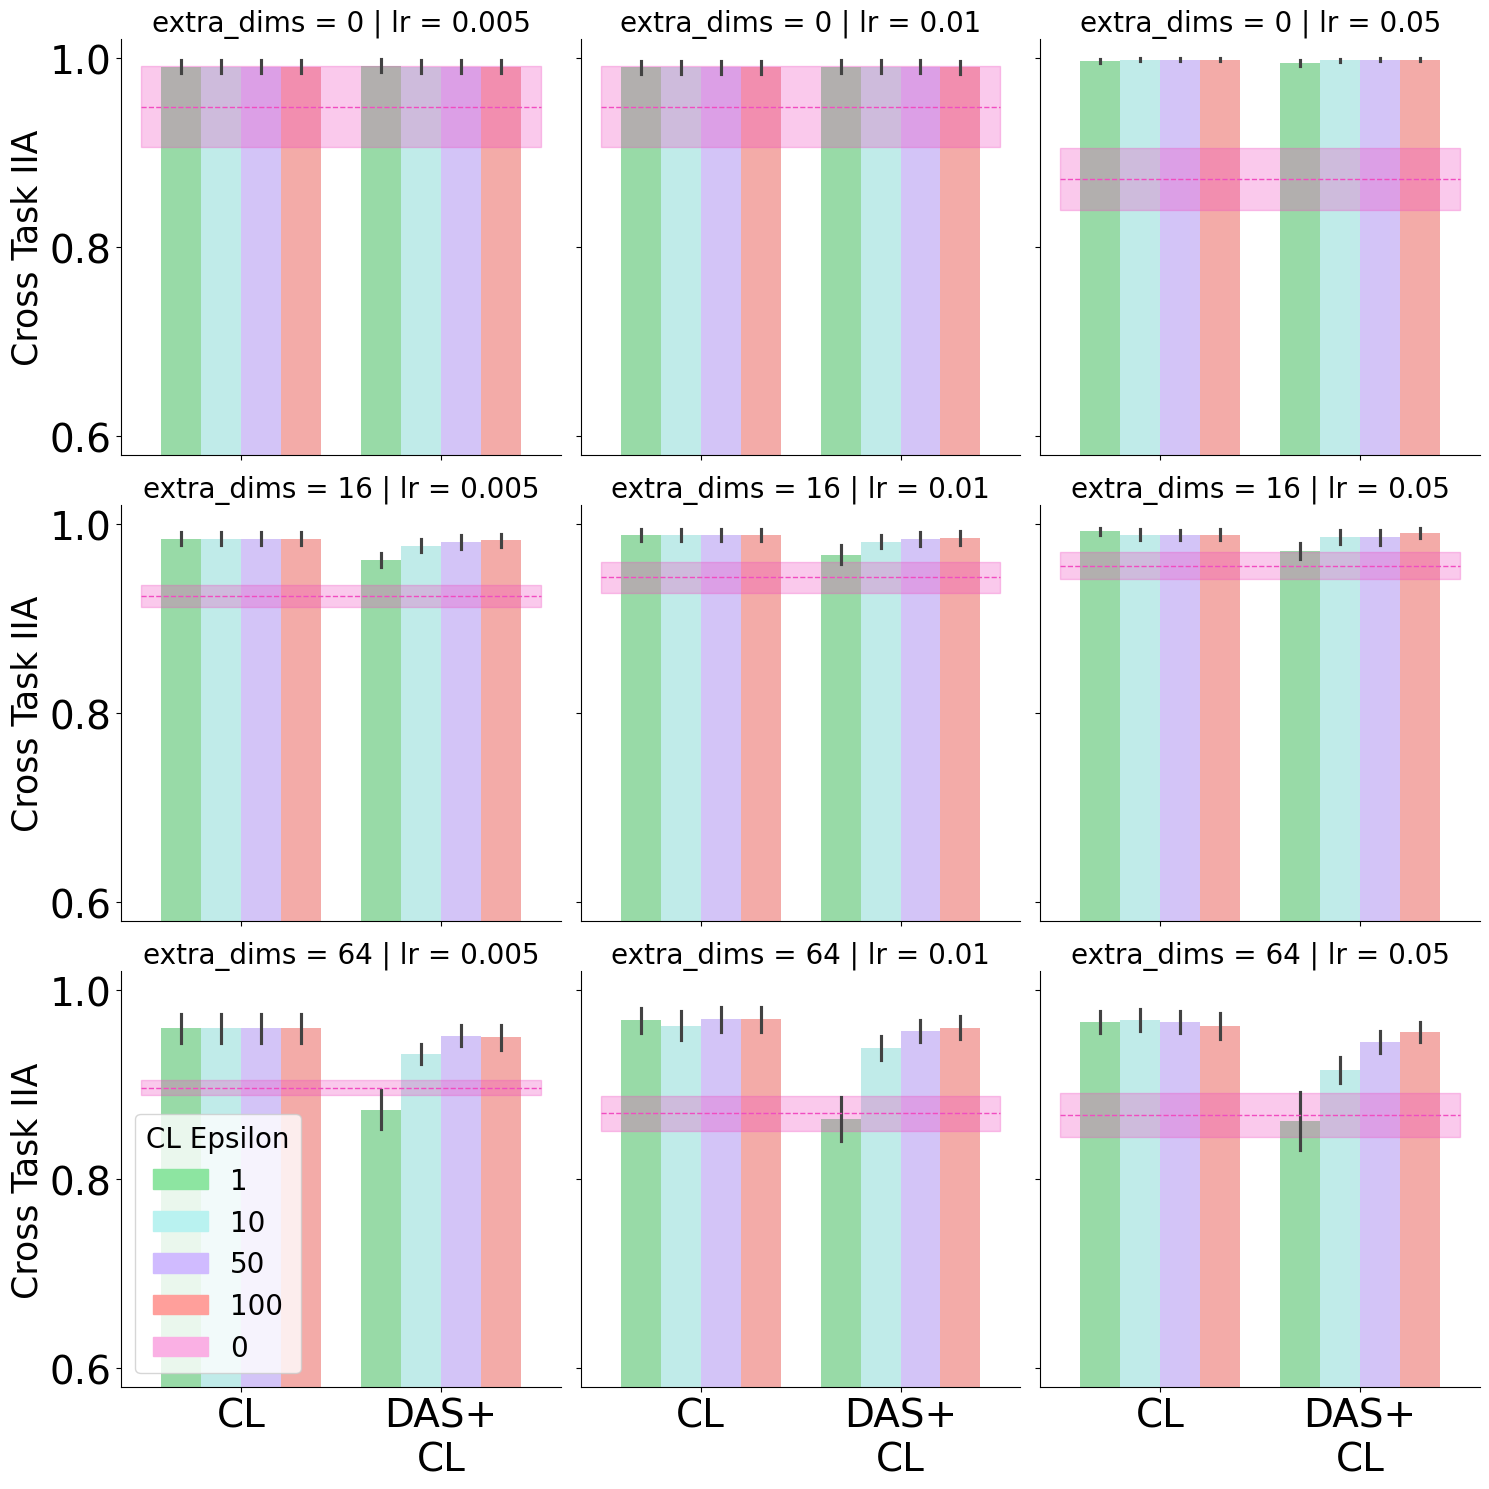

In [66]:
incl_filters = {
    #"mtx_type": ["orthog"],
    #"extra_dims": [64], # 16,],
    #"lr": [ 0.01 ],
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    "mask_dims": [1],
    "task_division": ["inner_square"],
    "loss_type": [CL,DAS,CLDAS],
}
excl_filters = {
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

y = "cross_actn_acc"
x = "loss_type"
excl_das_bars = True
hue = "cl_eps" #"loss_type"
col_name = "lr"
row_name = "extra_dims"
leg_title = "CL Epsilon" # " ".join([h.capitalize() for h in hue.split("_")])
incl_legend = True

if hue=="task_spacing":
    p = {
        "Dense": sns.color_palette("pastel")[color_order[0]],
        "Sparse": sns.color_palette("pastel")[color_order[1]],
    }
    pp = {
        "Dense": sns.color_palette("bright")[color_order[0]],
        "Sparse": sns.color_palette("bright")[color_order[1]],
    }
elif hue:
    p = {k: sns.color_palette("pastel")[int(color_order[i])] for i,k in enumerate(full_df[hue].unique())}
    pp = {k: sns.color_palette("bright")[int(color_order[i])] for i,k in enumerate(full_df[hue].unique())}
else:
    p = sns.color_palette("pastel")
    pp = sns.color_palette("bright")
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 20
legendsize = 20
linewidth = 4

ylabel = "Cross Task IIA" if "cross" in y else "Trained Task IIA" 

ylim = [0.58,1.02]
yticks = [0.6, 0.8, 1.0]
if "acc" not in y:
    if "row" in y:
        ylabel = ylabel.replace("Task IIA", "Row EMD")
        yticks = [0,0.025,0.05, 0.075, 0.1, 0.125, 0.15]
        ylim = [0,0.155]
    else:
        ylabel = ylabel.replace("Task IIA", "EMD")
        yticks = None
        ylim = None
print(y)
iia_threshold = 0


plot_df = full_df.copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)&(plot_df["actn_acc"]>iia_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()

actn_bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
bloss_acc = dict(plot_df.loc[actn_bools].groupby(hue)[y].mean())
bloss_err = dict(plot_df.loc[actn_bools].groupby(hue)[y].sem())
print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)

plot_df["emd"] = plot_df["emd"]/(plot_df["extra_dims"]+1)
plot_df["cross_emd"] = plot_df["cross_emd"]/(plot_df["extra_dims"]+1)
if excl_das_bars:
    temp_df = plot_df.loc[plot_df["loss_type"]!=DAS].copy()
else:
    temp_df = plot_df.copy()
g = sns.catplot(
    x=x, y=y,
    hue=hue,
    col=col_name,
    row=row_name,
    data=temp_df,
    ax=ax,
    palette=p,
    kind="bar",
    errorbar="se",
    legend=False,
)
n_cols = len(set(temp_df[col_name]))
for i,(_, ax) in enumerate(g.axes_dict.items()):
    row,col = i//n_cols, i%n_cols
    plt.sca(ax)
    title = ax.get_title() 
    r,c = title.split(" | ")
    rk,rv = r.strip().split(" = ")
    ck,cv = c.strip().split(" = ")
    try: rv = float(rv)
    except: pass
    try: cv = float(cv)
    except: pass

    # Baseline
    err_alpha = 0.3
    linewidth = 1
    actn_bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
    rcbools = (plot_df[rk]==rv)&(plot_df[ck]==cv)
    bloss_acc = dict(plot_df.loc[actn_bools&rcbools].groupby(hue)[y].mean())
    bloss_err = dict(plot_df.loc[actn_bools&rcbools].groupby(hue)[y].sem())
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    for j,k in enumerate(bloss_acc):
        acc = bloss_acc[k]
        err = bloss_err[k]
        color = pp[k]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth, label=k)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color,)
    
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel("", fontsize=labelsize)
    plt.ylabel(ylabel, fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    if yticks is None:
        plt.yticks(fontsize=ticksize)
    else:
        plt.yticks(yticks, fontsize=ticksize)
    plt.title(
        ax.get_title(),
        fontsize=titlesize
    )
    if i==6 and incl_legend:
        handles =[mpatches.Patch(color=v, label=k) for k,v in p.items()]
        plt.legend(
            title=leg_title,
            fontsize=legendsize,
            title_fontsize=legendsize,
            handles=handles,
        )
    else:
        plt.legend(
            loc="lower left",
            title=leg_title,
            fontsize=legendsize,
            title_fontsize=legendsize
        ).set_visible(False)

plt.tight_layout()
prefix = "ood" if "cross" in y else "indistr"
plt.savefig(f"figs/{prefix}_ablations_c{col_name}_r{row_name}_{y}.png", dpi=600, bbox_inches="tight")
plt.savefig(f"figs/{prefix}_ablations_c{col_name}_r{row_name}_{y}.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [198]:
from scipy import stats

def regress(x,y):
    m = stats.linregress(x.squeeze(),y)
    return m.slope, m.intercept, m.pvalue, m.rvalue**2
x = np.random.randn(100)
f = lambda x: 2*x+1
y = f(x)
regress(x,y)
y = "cross_actn_acc"
#x = "cl_eps"
#hue = "task_spacing"
x_axis = "incl_extra"
hue = "loss_type"
col = "lr"
row = "extra_dims"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
lin_regs = {
    x_axis: [],
    hue: [],
    col: [],
    row: [],
    "emd_type": [],
    "coef": [],
    "intercept": [],
    "pvalue": [],
    "rvalue": [],
}
params = []
pvals = []

temp_df = plot_df.copy()
for xx in set(temp_df[x_axis]):
    ttemp = temp_df.loc[temp_df[x_axis]==xx]
    for hhue in set(ttemp[hue]):
        tttemp = ttemp.loc[ttemp[hue]==hhue]
        if len(tttemp)==0: continue
        for c in set(tttemp[col]):
            tttt = tttemp.loc[tttemp[col]==c]
            if len(tttt)==0: continue
            for r in set(tttt[row]):
                t = tttt.loc[tttt[row]==r]
                if len(t)==0: continue
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
df = pd.DataFrame(lin_regs)
df

,incl_extra,loss_type,lr,extra_dims,emd_type,coef,intercept,pvalue,rvalue
0,False,DAS+\nCL,0.050,0,cross,0.021116,0.996861,6.054262e-01,0.012333
1,False,DAS+\nCL,0.050,0,within,-0.156529,0.998485,4.340395e-01,0.028054
2,False,DAS+\nCL,0.050,0,row_cross,0.021116,0.996861,6.054262e-01,0.012333
3,False,DAS+\nCL,0.050,0,row_within,-0.156529,0.998485,4.340397e-01,0.028054
4,False,DAS+\nCL,0.050,16,cross,-0.050401,0.999906,7.360895e-02,0.138245
5,False,DAS+\nCL,0.050,16,within,-0.041063,0.996899,1.209068e-01,0.105805
6,False,DAS+\nCL,0.050,16,row_cross,-0.452270,0.998435,1.160850e-03,0.387483
7,False,DAS+\nCL,0.050,16,row_within,-0.366453,0.990965,3.333054e-02,0.189817
8,False,DAS+\nCL,0.050,64,cross,-0.488266,1.100405,7.995273e-07,0.677041
9,False,DAS+\nCL,0.050,64,within,-0.395396,1.067598,1.971929e-06,0.649993


In [199]:
df.loc[df["lr"]==0.05].groupby(["emd_type","loss_type"]).mean(numeric_only=True)

incl_extra    lr  extra_dims      coef  intercept    pvalue    rvalue
emd_type   loss_type                                                                       
cross      CL                0.0  0.05   26.666667 -0.216628   1.048104  0.139621  0.130069
           DAS               0.0  0.05   26.666667 -0.119301   0.932266  0.519410  0.219059
           DAS+\nCL          0.0  0.05   26.666667 -0.172517   1.032391  0.226345  0.275873
row_cross  CL                0.0  0.05   26.666667 -0.253894   0.990079  0.173528  0.175320
           DAS               0.0  0.05   26.666667 -0.088374   0.922116  0.391921  0.295971
           DAS+\nCL          0.0  0.05   26.666667 -0.293172   0.984177  0.204184  0.232022
row_within CL                0.0  0.05   26.666667  0.158610   0.983169  0.463696  0.045895
           DAS               0.0  0.05   26.666667 -0.629246   0.939852  0.373070  0.408223
           DAS+\nCL          0.0  0.05   26.666667 -0.379059   0.982384  0.155791  0.283647
within     CL                0.0  0.05   26.666667  0.196838   0.913926  0.104863  0.141082
           DAS               0.0  0.05   26.666667 -0.638590   0.947051  0.326572  0.373902
           DAS+\nCL          0.0  0.05   26.666667 -0.197663   1.020994  0.184983  0.261284

In [200]:
for emd_type in ["cross_emd", "emd", "cross_row_emd", "row_emd"]:
    coef,intercept,pvalue,rvalue = regress(np.asarray(temp_df[emd_type])[:,None], np.asarray(temp_df["cross_actn_acc"]))
    print("EMD Type:", emd_type)
    print("\tCoef:", coef)
    print("\tIntrc:", intercept)
    print("\tpvalue:", pvalue)
    print("\trvalue:", rvalue)


EMD Type: cross_emd
	Coef: -0.1327306054444725
	Intrc: 0.9971431569104588
	pvalue: 1.5696896569664304e-41
	rvalue: 0.3140228701982056
EMD Type: emd
	Coef: -0.1030179568224296
	Intrc: 0.9902457718851694
	pvalue: 4.446523575881545e-29
	rvalue: 0.228238642190296
EMD Type: cross_row_emd
	Coef: -0.1295763245707139
	Intrc: 0.976871678174242
	pvalue: 1.2462885544962332e-42
	rvalue: 0.32113531430386255
EMD Type: row_emd
	Coef: -0.0844566198588049
	Intrc: 0.9727061722622098
	pvalue: 5.4206583686644544e-27
	rvalue: 0.21287880405717127
